In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Attention Mechanisms+
This exercise is based on Lukas Heinrich's lecture about Transformers in the course "Modern Deep Learning in Physics" @ TUM. 
In this exercise we will write a attention mechanism to solve the following problem

"Given a length 10 sequence of integers, are there more '2s' than '4s' ?"

This could of course be easily handled by a fully connected network, but we'll force the network
to learn this by learning to place attention on the right values. I.e. the strategy is

* embed the individual integer into a high-dimensional vector (using torch.nn.Embedding)
* once we have those embeddings compute how much attention to place on each vector by comparing "key" values computed from the embedded values 
* compute "answer" values to our query by weighting the individual responsed by their attention value


$$
v_{ik} = \mathrm{softmax}_\mathrm{keys}(\frac{q_{i}\cdot k_{j}}{\sqrt{d}}) v_{jk}
$$


## Preparation
Before we bring this all to live in a written class, we go through each step in order to understand it properly. 

We will use the QKV - Self Attention Encoding Part.
For doing so we will replicate the shown procedure:


<img src="Grafiken/text1.svg" alt="Attention">

### Generating Data
Write a data-generating function that produces a batch of N examples or length-10 sequences of random integers between 0 and 9 as well as a binary label indicating whether the sequence has more 2s than 4s. The output should return (X,y), where X has shape `(N,10)` and y has shape `(N,1)`

```python
def make_batch(N):
    ...
```

In [4]:
def make_batch(N):
    t = torch.randint(0,9, size=(N,10))
    more_twos_than_fours = torch.FloatTensor([len(x[x==2]) > len(x[x==7]) for x in t])

    return t, more_twos_than_fours.reshape(-1,1)


### Embedding the Integers
Deep Learning works well in higher dimensions. So we'll embed the 10 possible integers into a vector space using `torch.nn.Embedding`


* Verify that using e.g. a module like `torch.nn.Embedding(10,embed_dim)` achieves this
* Take a random vector of integers of shape (N,M) and evaluate them through an embedding module
* Does the output dimension make sense?

**Alternatively:**


One can embed the integers inot a vector space such that one uses One-Hot Encoding and sending it through a `torch.nn.Linear(one_hot_dim, embed_dim)`


In [16]:
x, y = make_batch(5)

In [17]:
embed_dim = 15

embed = torch.nn.Embedding(10, embed_dim)
embedded = embed(x)

### Extracting Keys and Values 

Once data is embedded we can extract keys and values by a linear projection

* For 2 linear layers `torch.nn.Linear(embed_dim,att_dim)` we can extract keys and values for the output of the previous step
* verify that this works from a shape perspective

In [18]:
att_dim = 64

In [19]:
key_proj = torch.nn.Linear(embed_dim, att_dim)
val_proj = torch.nn.Linear(embed_dim, 1)

In [20]:
key_proj(embedded).shape , val_proj(embedded).shape 

(torch.Size([5, 10, 64]), torch.Size([5, 10, 1]))

## Computing Attention
<img src="Grafiken/text1.svg" alt="Attention">
Implement the Attention-formula from above in a batched manner, such that for a input set of sequences `(N,10)`
you get an output set of attention-weighted values `(N,1)`

* It's easiest when using the function `torch.einsum` which uses the Einstein summation you may be familiar with from special relativity
* e.g. a "batched" dot product is performed using `einsum('bik,bjk->bij')` where `b` indicates the batch index, `i` and `j` are position indices and `k` are the coordinates of the vectors


--> **Some hints**
* Keep in mind that the dimension $\sqrt{d}$in the softmax function is your `att_dim`
* Initiate your query randomly in the size `1,att_dim`
* query and keys: einsum --> `'ik,bjk->bij'`
* for the softmax use `dim=-1`

In [21]:
query = torch.randn(1,att_dim)
keys = key_proj(embedded)
values = val_proj(embedded)

In [22]:
qk = torch.einsum('ik,bjk->bij',query,keys)
att = torch.softmax(qk/att_dim**0.5 , dim=-1)

aggreg = torch.einsum('bij,bjk->bik',att,values)

# Integrate into a Module

Complete the following torch Module:

To use the `self.nn` make sure to have an input shaped like `torch.Size([batch, att_dim])`

* For the `forward(x)` function have a look at the Graph in 1.2 again and follow along
```python
class AttentionModel(torch.nn.Module):
    def __init__(self):
        super(AttentionModel,self).__init__()
        self.embed_dim = 5
        self.att_dim = 5
        self.embed = torch.nn.Embedding(10,self.embed_dim)
        
        #one query
        self.query  = torch.nn.Parameter(torch.randn(1,self.att_dim))
        
        #used to compute keys
        self.WK = torch.nn.Linear(self.embed_dim,self.att_dim)
        
        #used to compute values
        self.WV = torch.nn.Linear(self.embed_dim,1)
        
        #final decision based on attention-weighted value
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(1,200),
            torch.nn.ReLU(),
            torch.nn.Linear(200,1),
            torch.nn.Sigmoid(),
        )

    def attention(self,x):
        # compute attention
        ...
    
    def values(self,x):
        # compute values
        ...
                
    def forward(self,x):
        # compute final classification using attention, values and final NN
      
```

In [6]:
class AttentionModel(torch.nn.Module):
    def __init__(self):
        super(AttentionModel, self).__init__()
        self.embed_dim = 3
        self.att_dim = 3
        self.embed = torch.nn.Embedding(10, self.embed_dim)
        
        # one query
        self.query = torch.nn.Parameter(torch.randn(1, self.att_dim))
        
        # used to compute keys
        self.WK = torch.nn.Linear(self.embed_dim, self.att_dim)
        
        # used to compute values
        self.WV = torch.nn.Linear(self.embed_dim, 3)
        
        # final decision based on attention-weighted value
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(3, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 1),
            torch.nn.Sigmoid(),
        )

    def attention(self, x):
        queries = self.query
        keys = self.WK(x)
        qk = torch.einsum('ik,bjk->bij', queries, keys)
        att = torch.softmax(qk / (self.att_dim ** 0.5), dim=-1)
        return att
    
    def values(self, x):
        return self.WV(x)

    def forward(self, x):
        x = self.embed(x)
        att = self.attention(x)
        values = self.values(x)
        aggreg = torch.einsum('bij,bjk->bik', att, values)
        mlp_result = self.nn(aggreg[:, 0, :])
        return mlp_result


## Predefine Plot Function
Use this given function later on to visualize your training. 
Just execute the following cell.

In [7]:
def plot(model,N,traj):
    x,y = make_batch(N)
    f,axarr = plt.subplots(1,3)
    f.set_size_inches(10,2)
    ax = axarr[0]
    at = model.attention(model.embed(x))[:,0,:].detach().numpy()
    ax.imshow(at)
    ax = axarr[1]
    
    
    vals = model.values(model.embed(x))[:,:,0].detach().numpy()
    nan = np.ones_like(vals)*np.nan
    nan = np.where(at > 0.1, vals, nan)
    ax.imshow(nan,vmin = -1, vmax = 1)
    for i,xx in enumerate(x):
        for j,xxx in enumerate(xx):
            ax = axarr[0]
            ax.text(j,i,xxx.numpy(), c = 'r' if (xxx in [2,4]) else 'w')    
            ax = axarr[1]
            ax.text(j,i,xxx.numpy(), c = 'r' if (xxx in [2,4]) else 'w')    
    ax = axarr[2]
    ax.plot(traj)
    f.set_tight_layout(True)


In [8]:
def plot_vec(Q, K, V):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Set up the figure and 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the vectors
    ax.quiver(0, 0, 0, Q[0], Q[1], Q[2], color='r', label='Q')
    ax.quiver(0, 0, 0, K[0], K[1], K[2], color='g', label='K')
    ax.quiver(0, 0, 0, V[0], V[1], V[2], color='b', label='V')

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add legend
    ax.legend()

    # Set the limits of the plot
    ax.set_xlim([0, max(Q[0], K[0], V[0]) + 1])
    ax.set_ylim([0, max(Q[1], K[1], V[1]) + 1])
    ax.set_zlim([0, max(Q[2], K[2], V[2]) + 1])

    # Show the plot
    plt.show()

## Train the Model

In [12]:
def train(train_steps=5000):
    model = AttentionModel()
    opt = torch.optim.Adam(model.parameters(),lr = 1e-4)

    traj = []
    for i in range(train_steps):
        x,y = make_batch(100)
        p = model.forward(x)
        loss = torch.nn.functional.binary_cross_entropy(p,y)
        loss.backward()
        traj.append(float(loss))
        if i % 1500 == 0:
            Q = model.query.detach().numpy()[0]
            K = model.WK(2).detach().numpy()[0]
            V = model.WV(2).detach().numpy()[0]
            plot_vec(Q,K,V)
            # plot(model,5,traj)
            # plt.savefig('attention_{}.png'.format(str(i).zfill(6))) # not needed to save all the images to disk
            plt.show()
            print(i,loss)
        opt.step()
        opt.zero_grad()
    return traj


In [13]:
training = train()

TypeError: linear(): argument 'input' (position 1) must be Tensor, not int

# Bonus
Maybe you want to change our rule to learn. 
You can play around how to properly choose the hyperparameters, such like`embed_dim`, `att_dim` and number of training steps in order to learn more complicated rules such like:  
`torch.FloatTensor([1 if (len(x[x==2]) > len(x[x==4])) or (len(x[x==5]) == len(x[x==8])) else 0 for x in t])`

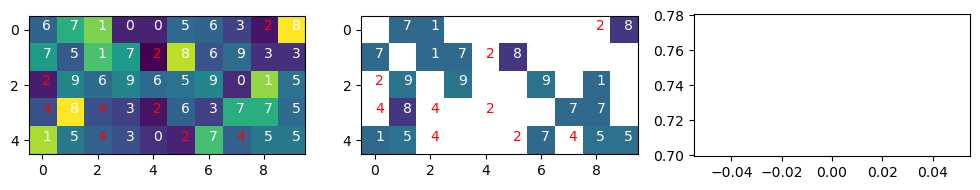

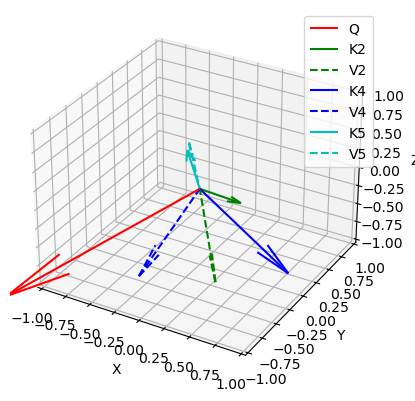

0 0.7400949597358704


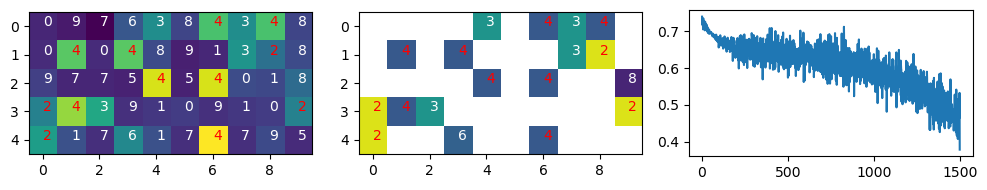

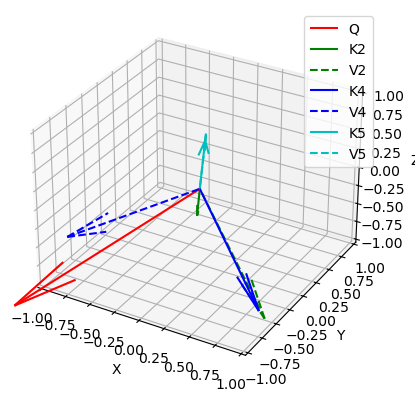

1500 0.37834715843200684


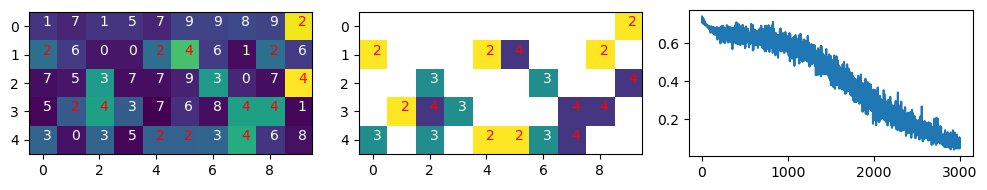

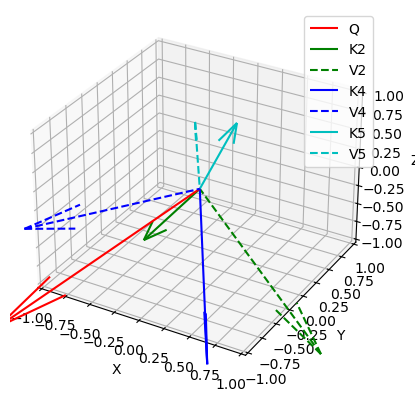

3000 0.09022361785173416


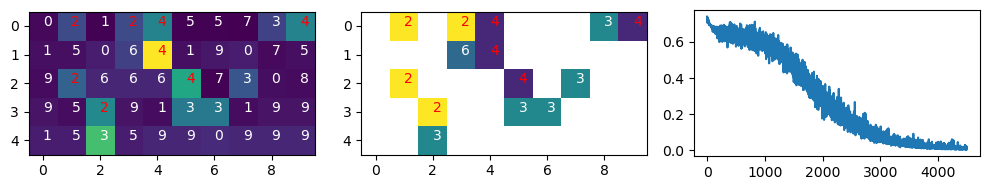

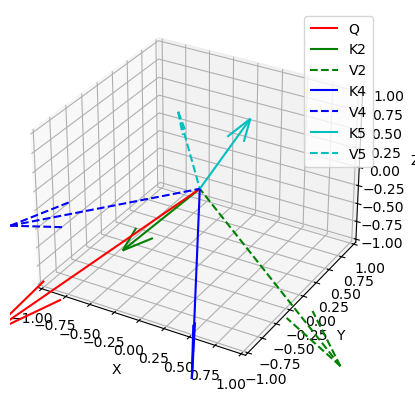

4500 0.019000889733433723


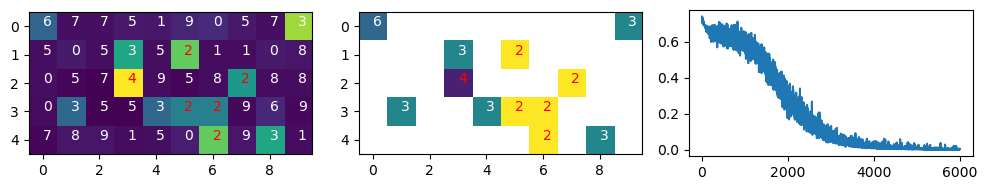

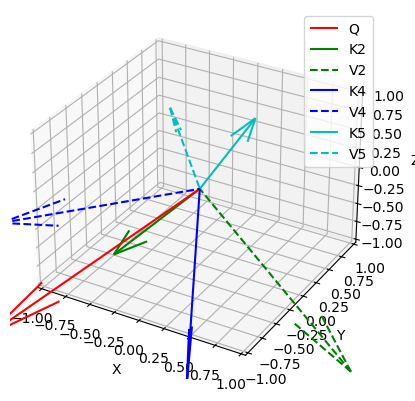

6000 0.003927284851670265


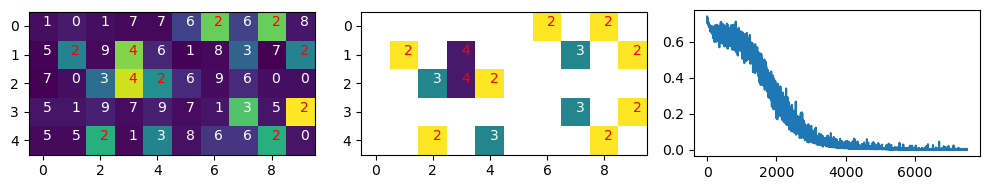

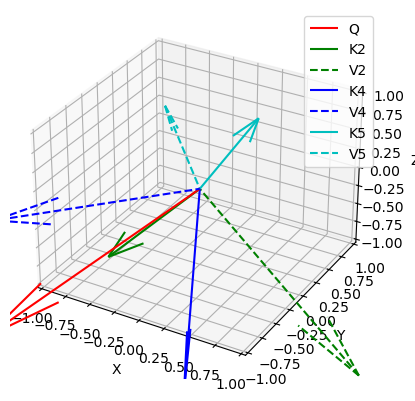

7500 0.0026251741219311953


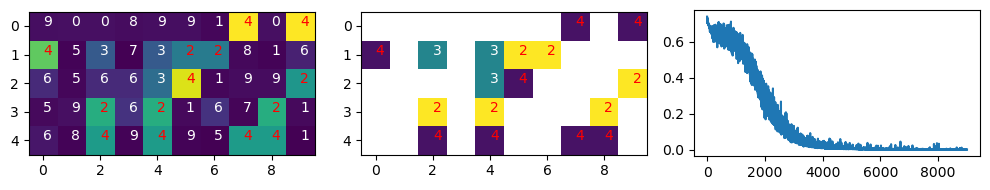

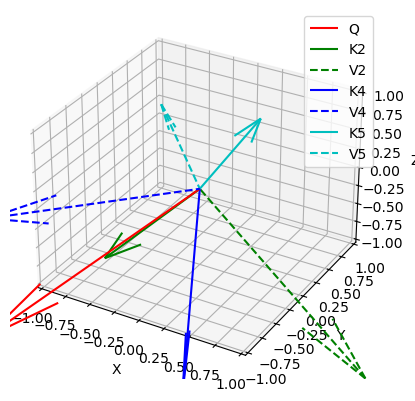

9000 0.0004057247133459896


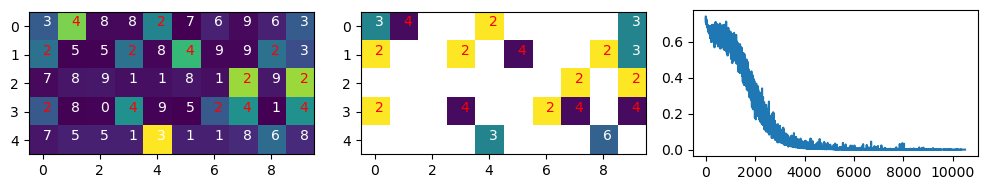

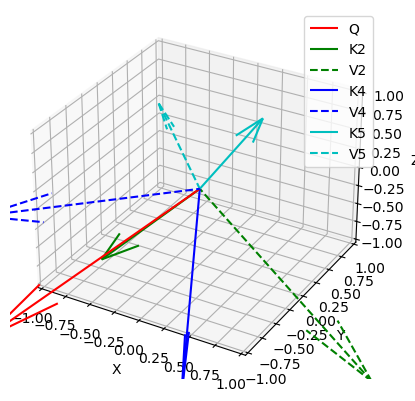

10500 0.00010687434405554086


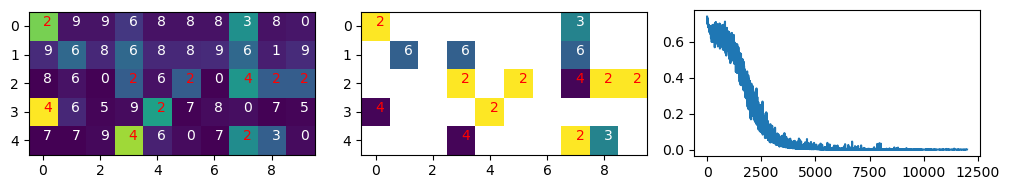

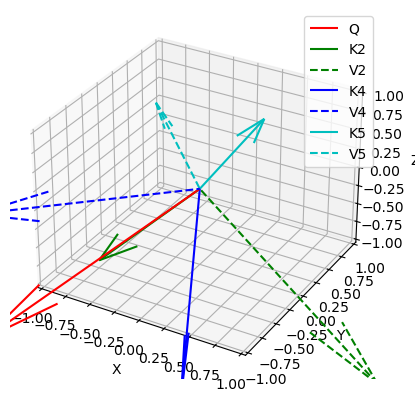

12000 0.000509237521328032


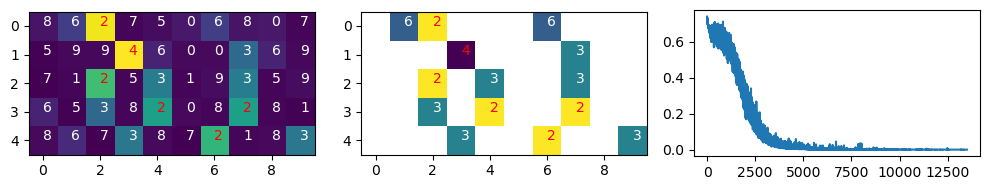

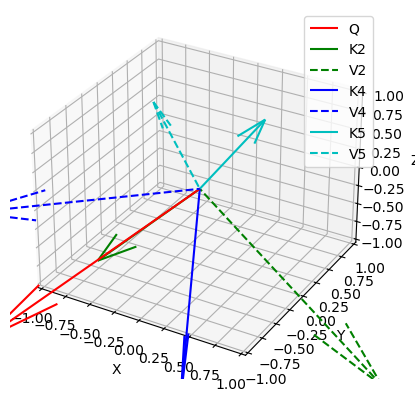

13500 9.241046427632682e-06


[0.7400949597358704,
 0.7179675102233887,
 0.7206695675849915,
 0.7340599894523621,
 0.729856014251709,
 0.724256694316864,
 0.7055476903915405,
 0.7355234026908875,
 0.7274730801582336,
 0.7177715301513672,
 0.7137454152107239,
 0.7082120776176453,
 0.7277971506118774,
 0.7199938297271729,
 0.7220811247825623,
 0.7261622548103333,
 0.702898383140564,
 0.7115446329116821,
 0.7262588739395142,
 0.7187736630439758,
 0.7204286456108093,
 0.7157060503959656,
 0.7203295230865479,
 0.7181532382965088,
 0.715728759765625,
 0.707814633846283,
 0.7183073163032532,
 0.7147388458251953,
 0.7129322290420532,
 0.7102806568145752,
 0.7004701495170593,
 0.7120852470397949,
 0.7042092084884644,
 0.7042514085769653,
 0.6961970329284668,
 0.7050405740737915,
 0.7057972550392151,
 0.6984512209892273,
 0.6999808549880981,
 0.7008585333824158,
 0.6938784718513489,
 0.7050584554672241,
 0.6958218216896057,
 0.694317638874054,
 0.6991626024246216,
 0.6998350620269775,
 0.6958850622177124,
 0.697203516960144,

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class AttentionModel(nn.Module):
    def __init__(self):
        super(AttentionModel, self).__init__()
        self.embed_dim = 3
        self.att_dim = 3
        self.embed = nn.Embedding(10, self.embed_dim)
        
        # one query
        self.query = nn.Parameter(torch.randn(1, self.att_dim))
        
        # used to compute keys
        self.WK = nn.Linear(self.embed_dim, self.att_dim)
        
        # used to compute values
        self.WV = nn.Linear(self.embed_dim, 3)
        
        # final decision based on attention-weighted value
        self.nn = nn.Sequential(
            nn.Linear(3, 200),
            nn.ReLU(),
            nn.Linear(200, 1),
            nn.Sigmoid(),
        )

    def attention(self, x):
        queries = self.query
        keys = self.WK(x)
        qk = torch.einsum('ik,bjk->bij', queries, keys)
        att = torch.softmax(qk / (self.att_dim ** 0.5), dim=-1)
        return att
    
    def values(self, x):
        return self.WV(x)

    def forward(self, x):
        x = self.embed(x)
        att = self.attention(x)
        values = self.values(x)
        aggreg = torch.einsum('bij,bjk->bik', att, values)
        mlp_result = self.nn(aggreg[:, 0, :])
        return mlp_result

def plot_vec(Q, K2, V2, K4, V4, K5, V5):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the vectors for number 2
    ax.quiver(0, 0, 0, Q[0], Q[1], Q[2], color='r', label='Q')
    ax.quiver(0, 0, 0, K2[0], K2[1], K2[2], color='g', linestyle='-', label='K2')
    ax.quiver(0, 0, 0, V2[0], V2[1], V2[2], color='g', linestyle='--', label='V2')

    # Plot the vectors for number 4
    ax.quiver(0, 0, 0, K4[0], K4[1], K4[2], color='b', linestyle='-', label='K4')
    ax.quiver(0, 0, 0, V4[0], V4[1], V4[2], color='b', linestyle='--', label='V4')

    # Plot the vectors for number 5
    ax.quiver(0, 0, 0, K5[0], K5[1], K5[2], color='c', linestyle='-', label='K5')
    ax.quiver(0, 0, 0, V5[0], V5[1], V5[2], color='c', linestyle='--', label='V5')

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add legend
    ax.legend()

    # Set the limits of the plot
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)

    # Show the plot
    plt.show()

def make_batch(N):
    t = torch.randint(0, 10, size=(N, 10))
    more_twos_than_fours = torch.FloatTensor([len(x[x == 2]) > len(x[x == 4]) for x in t])
    return t, more_twos_than_fours.reshape(-1, 1)

def train(train_steps=15000):
    model = AttentionModel()
    opt = optim.Adam(model.parameters(), lr=1e-4)

    traj = []
    for i in range(train_steps):
        x, y = make_batch(100)
        p = model.forward(x)
        loss = nn.functional.binary_cross_entropy(p, y)
        loss.backward()
        opt.step()
        opt.zero_grad()

        traj.append(float(loss))
        if i % 1500 == 0:
            with torch.no_grad():
                Q = model.query.numpy()[0]
                embed_2 = model.embed(torch.tensor([2]))
                K2 = model.WK(embed_2).numpy()[0]
                V2 = model.WV(embed_2).numpy()[0]
                embed_4 = model.embed(torch.tensor([4]))
                K4 = model.WK(embed_4).numpy()[0]
                V4 = model.WV(embed_4).numpy()[0]
                embed_5 = model.embed(torch.tensor([5]))
                K5 = model.WK(embed_5).numpy()[0]
                V5 = model.WV(embed_5).numpy()[0]
                plot(model,5,traj)
                plot_vec(Q, K2, V2, K4, V4, K5, V5)
                print(i, loss.item())
    return traj

# Example training run
train()



In [ ]:
def plot_vec(Q, K, V):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Set up the figure and 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the vectors
    ax.quiver(0, 0, 0, Q[0], Q[1], Q[2], color='r', label='Q')
    ax.quiver(0, 0, 0, K[0], K[1], K[2], color='g', label='K')
    ax.quiver(0, 0, 0, V[0], V[1], V[2], color='b', label='V')

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add legend
    ax.legend()

    # Set the limits of the plot
    ax.set_xlim([0, max(Q[0], K[0], V[0]) + 1])
    ax.set_ylim([0, max(Q[1], K[1], V[1]) + 1])
    ax.set_zlim([0, max(Q[2], K[2], V[2]) + 1])

    # Show the plot
    plt.show()


/var/folders/k0/pdpm_bns0zb_5lqb4931xd7r0000gn/T/ipykernel_9813/2905370463.py:119: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  f.tight_layout()


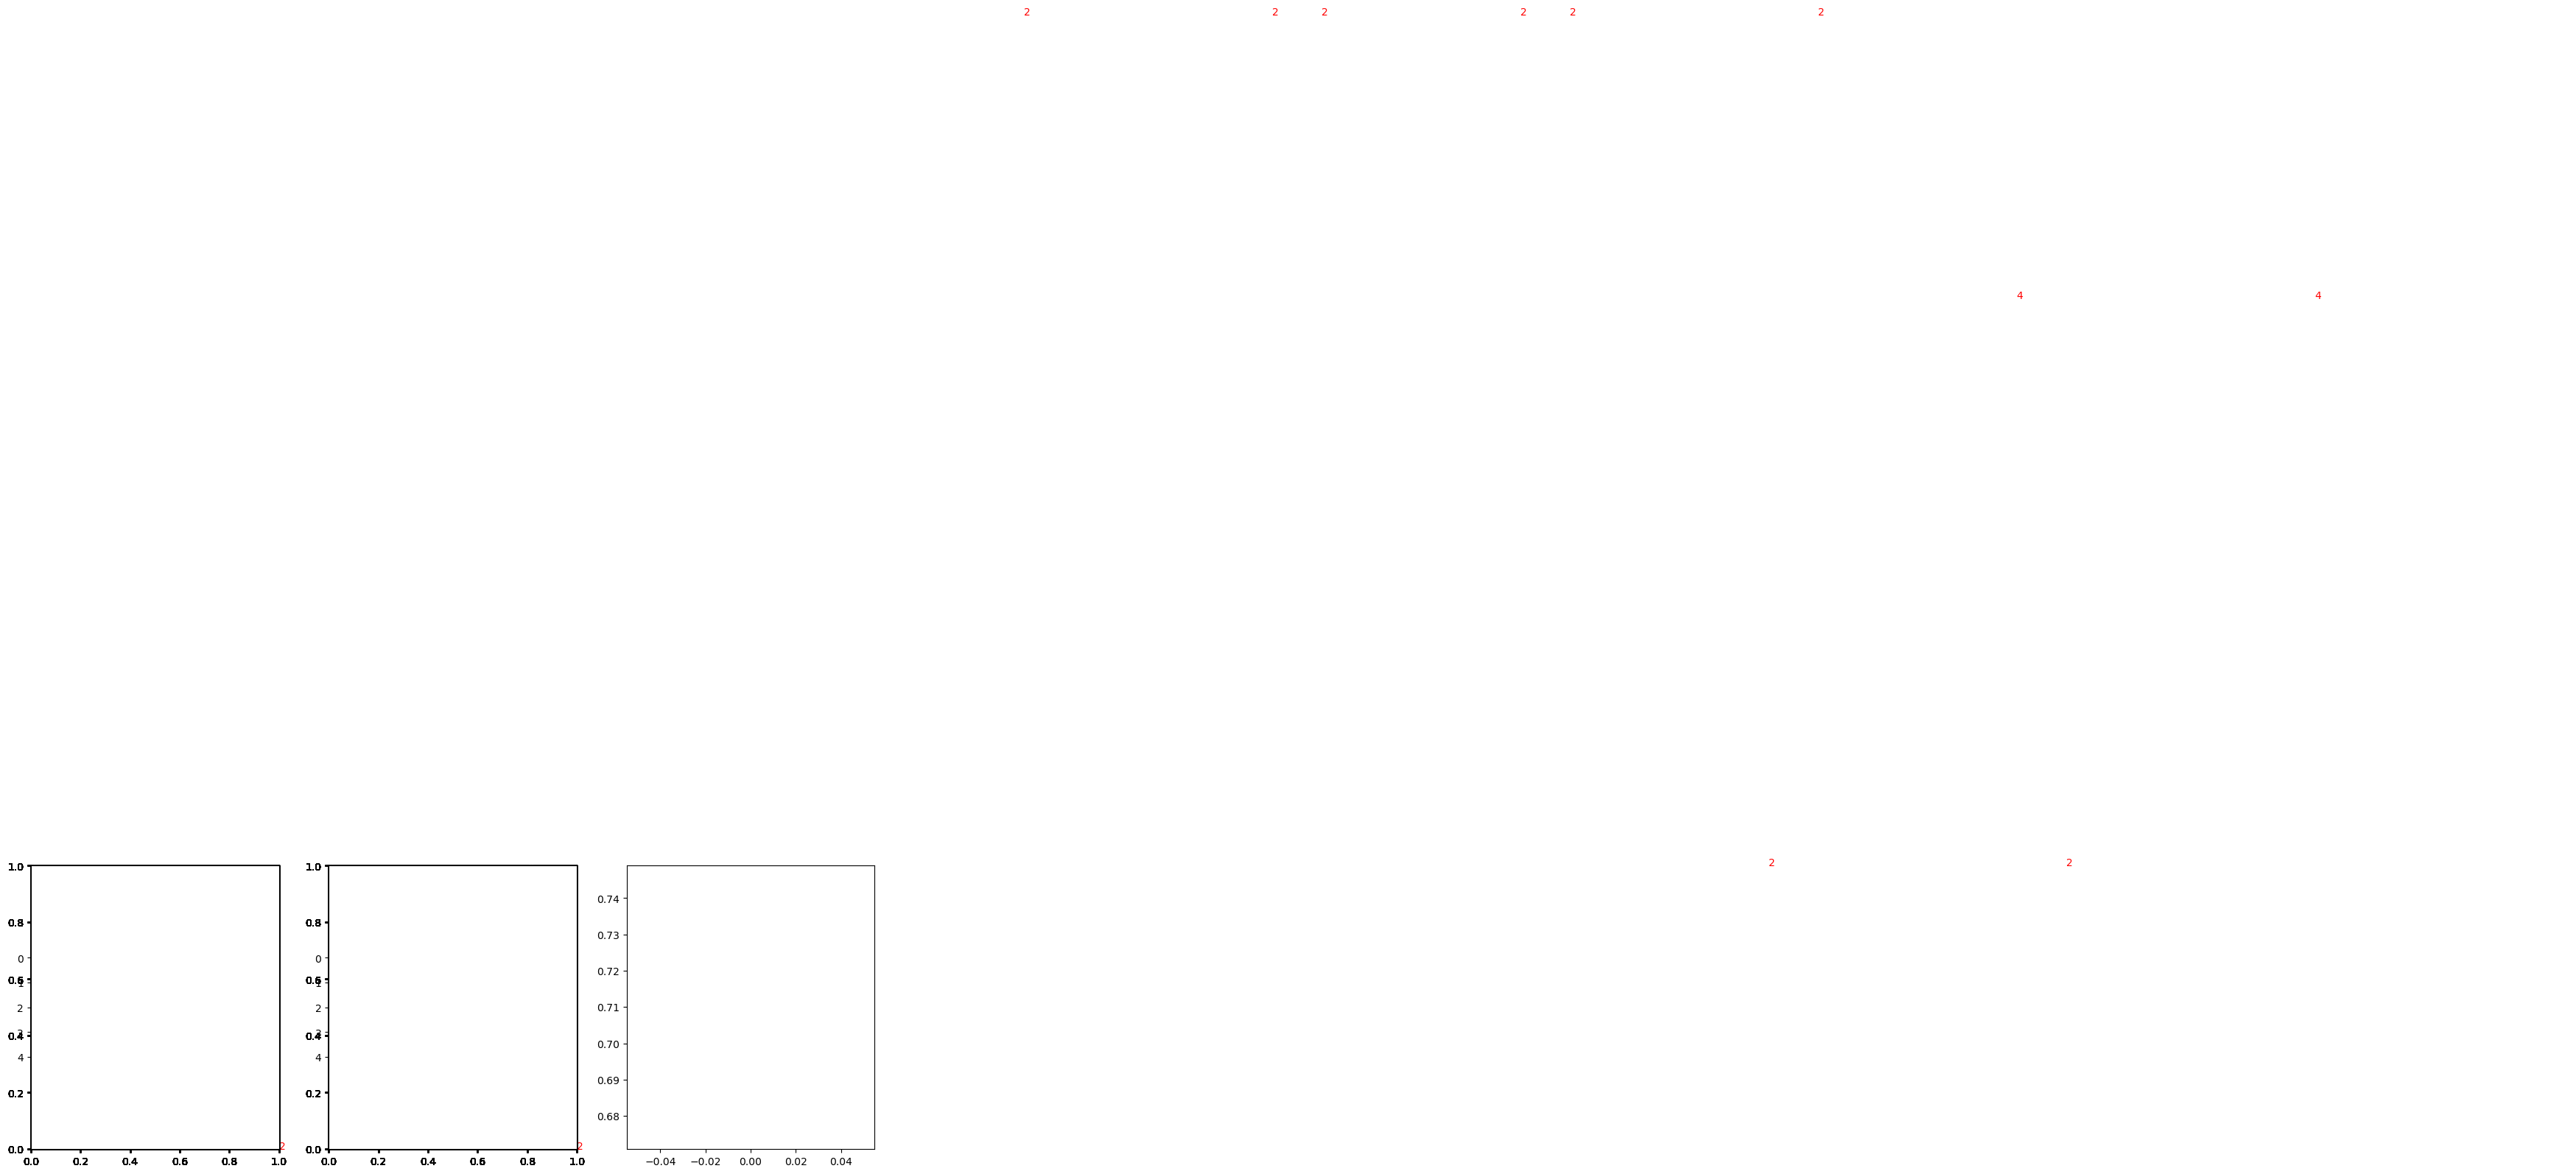

0 0.7098968625068665


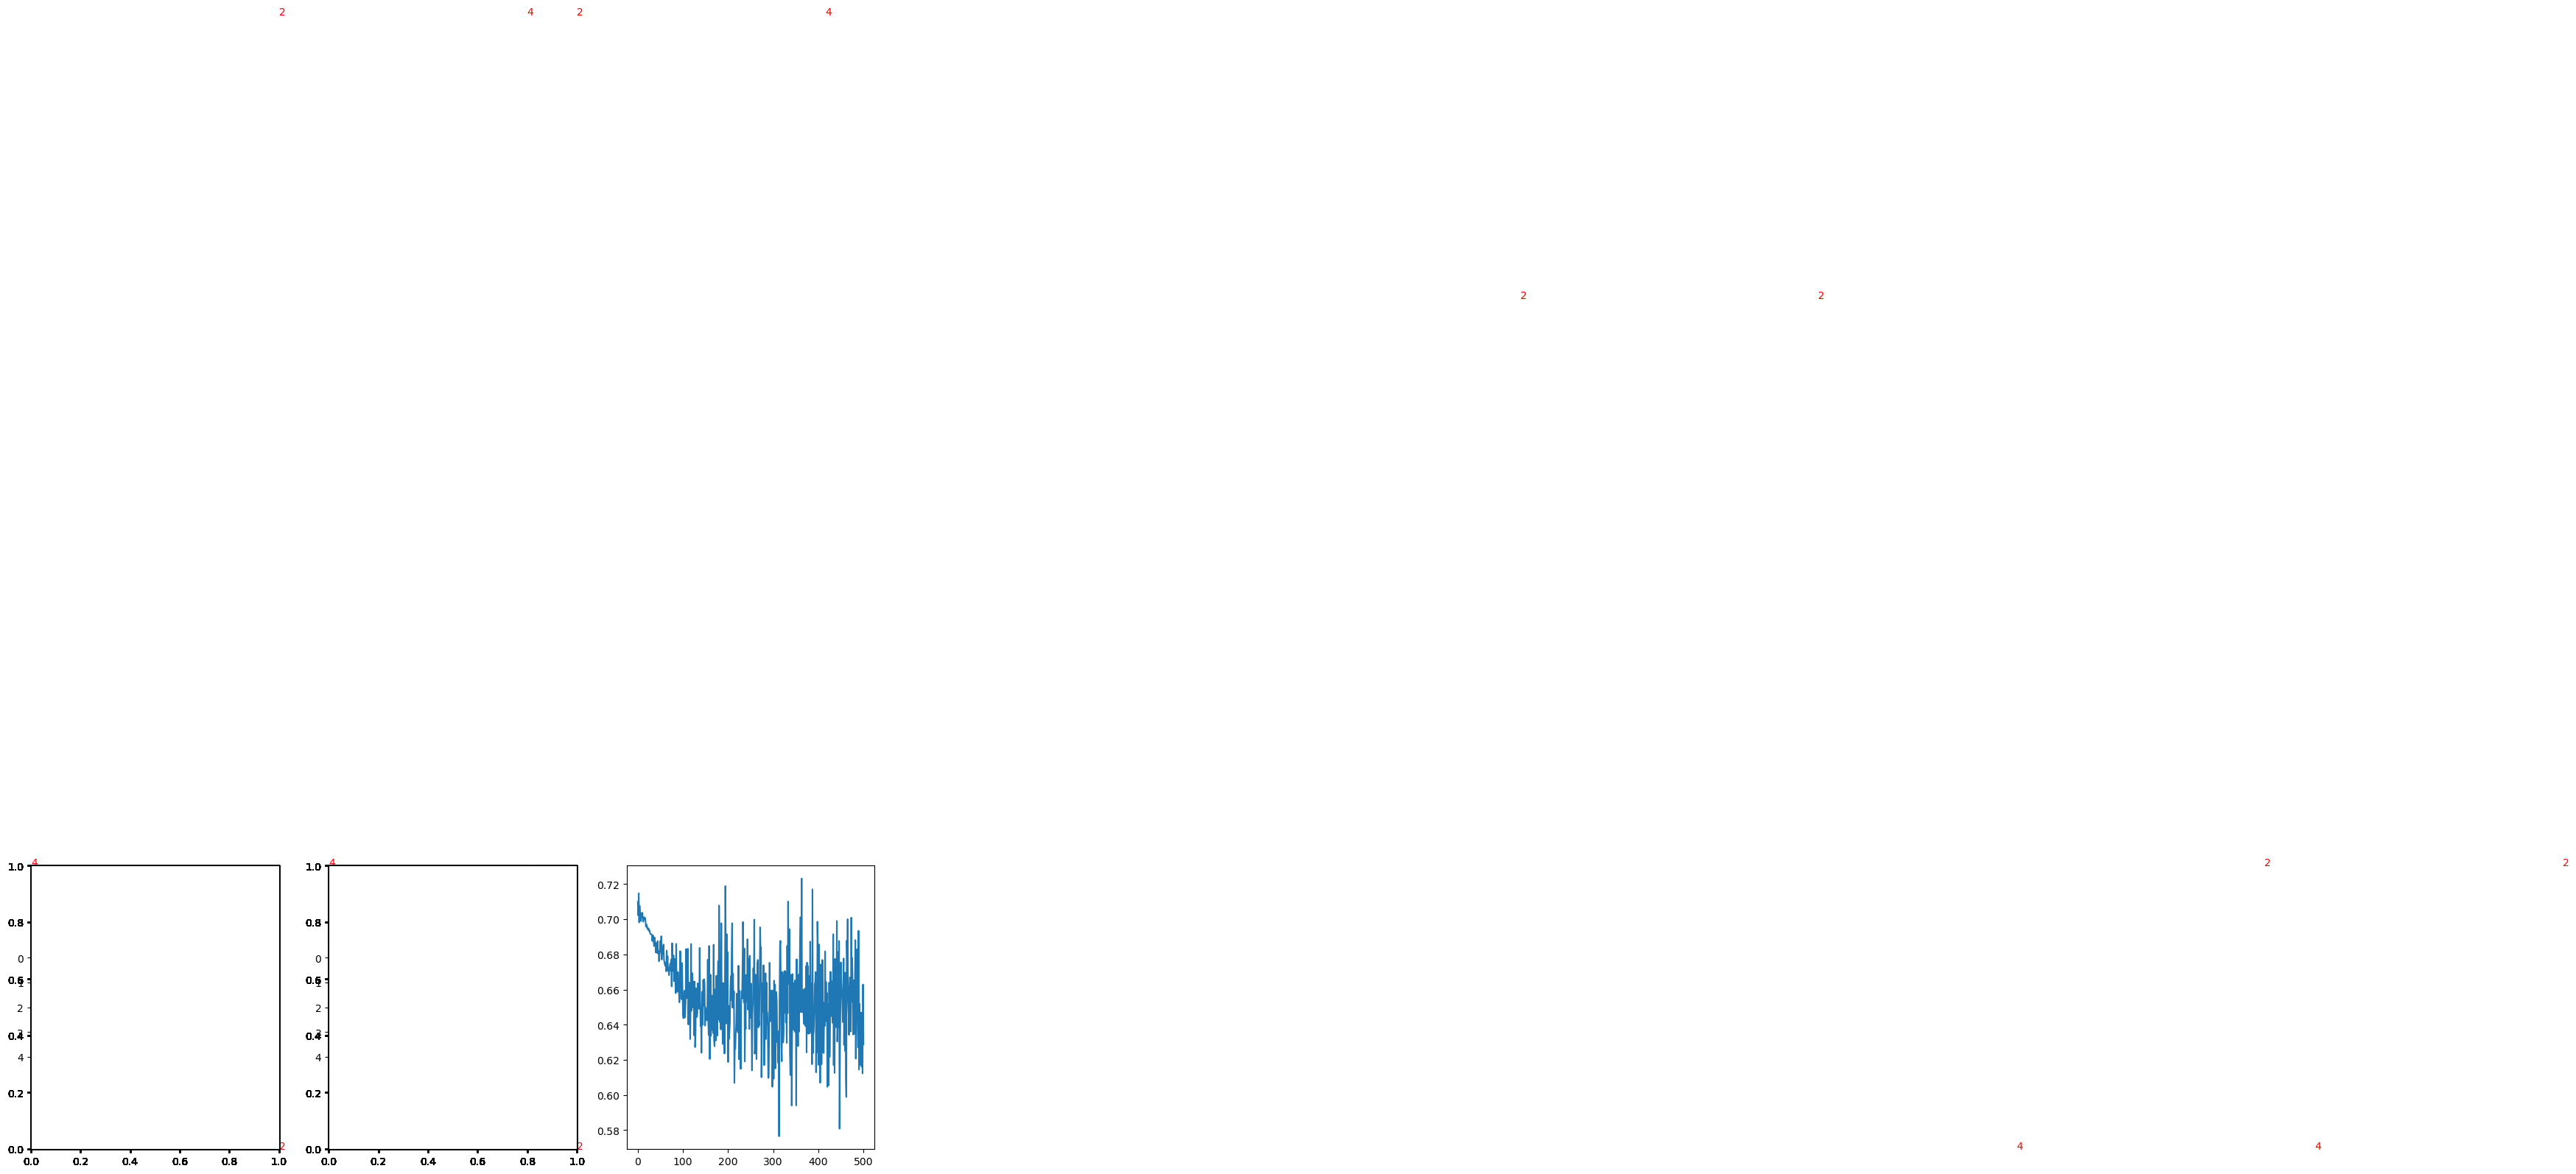

500 0.6287776827812195


[0.7098968625068665,
 0.702228844165802,
 0.7148196697235107,
 0.6982263326644897,
 0.7076857089996338,
 0.7031190395355225,
 0.7010909914970398,
 0.6989703178405762,
 0.7035582065582275,
 0.7012109160423279,
 0.7037505507469177,
 0.7013571858406067,
 0.6986789703369141,
 0.7002885341644287,
 0.701190173625946,
 0.6999396681785583,
 0.7007885575294495,
 0.6991342306137085,
 0.6958101391792297,
 0.6971545219421387,
 0.6962124705314636,
 0.6947391629219055,
 0.695244550704956,
 0.6938950419425964,
 0.6947037577629089,
 0.6933833360671997,
 0.693635880947113,
 0.6922088861465454,
 0.6916583180427551,
 0.6914739012718201,
 0.691493809223175,
 0.6913672089576721,
 0.6876413226127625,
 0.6902917623519897,
 0.6907803416252136,
 0.6879850625991821,
 0.6846904754638672,
 0.6897042989730835,
 0.68694669008255,
 0.6868714690208435,
 0.6810503602027893,
 0.6864427328109741,
 0.6815626621246338,
 0.6808223724365234,
 0.6875883340835571,
 0.6806984543800354,
 0.6816741824150085,
 0.6761338114738464,

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class AttentionModel(nn.Module):
    def __init__(self):
        super(AttentionModel, self).__init__()
        self.embed_dim = 3
        self.att_dim = 3
        self.embed = nn.Embedding(10, self.embed_dim)
        
        # one query
        self.query = nn.Parameter(torch.randn(1, self.att_dim))
        
        # used to compute keys
        self.WK = nn.Linear(self.embed_dim, self.att_dim)
        
        # used to compute values
        self.WV = nn.Linear(self.embed_dim, 3)
        
        # final decision based on attention-weighted value
        self.nn = nn.Sequential(
            nn.Linear(3, 200),
            nn.ReLU(),
            nn.Linear(200, 1),
            nn.Sigmoid(),
        )

    def attention(self, x):
        queries = self.query
        keys = self.WK(x)
        qk = torch.einsum('ik,bjk->bij', queries, keys)
        att = torch.softmax(qk / (self.att_dim ** 0.5), dim=-1)
        return att
    
    def values(self, x):
        return self.WV(x)

    def forward(self, x):
        x = self.embed(x)
        att = self.attention(x)
        values = self.values(x)
        aggreg = torch.einsum('bij,bjk->bik', att, values)
        mlp_result = self.nn(aggreg[:, 0, :])
        return mlp_result

def plot_vec(ax, Q, K2, V2, K4, V4, K5, V5):
    # Plot the vectors for number 2
    ax.quiver(0, 0, 0, Q[0], Q[1], Q[2], color='r', label='Q')
    ax.quiver(0, 0, 0, K2[0], K2[1], K2[2], color='g', arrow_length_ratio=0.1, label='K2')
    ax.quiver(0, 0, 0, V2[0], V2[1], V2[2], color='g', linestyle='--', arrow_length_ratio=0.1, label='V2')

    # Plot the vectors for number 4
    ax.quiver(0, 0, 0, K4[0], K4[1], K4[2], color='b', arrow_length_ratio=0.1, label='K4')
    ax.quiver(0, 0, 0, V4[0], V4[1], V4[2], color='b', linestyle='--', arrow_length_ratio=0.1, label='V4')

    # Plot the vectors for number 5
    ax.quiver(0, 0, 0, K5[0], K5[1], K5[2], color='c', arrow_length_ratio=0.1, label='K5')
    ax.quiver(0, 0, 0, V5[0], V5[1], V5[2], color='c', linestyle='--', arrow_length_ratio=0.1, label='V5')

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add legend
    ax.legend()

    # Set the limits of the plot
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

def plot_all(model, N, traj):
    x, y = make_batch(N)
    f = plt.figure(figsize=(20, 5))
    
    # Plot 3D vectors
    ax3d = fig.add_subplot(141, projection='3d')
    with torch.no_grad():
        Q = model.query.numpy()[0]
        embed_2 = model.embed(torch.tensor([2]))
        K2 = model.WK(embed_2).numpy()[0]
        V2 = model.WV(embed_2).numpy()[0]
        embed_4 = model.embed(torch.tensor([4]))
        K4 = model.WK(embed_4).numpy()[0]
        V4 = model.WV(embed_4).numpy()[0]
        embed_5 = model.embed(torch.tensor([5]))
        K5 = model.WK(embed_5).numpy()[0]
        V5 = model.WV(embed_5).numpy()[0]
        plot_vec(ax3d, Q, K2, V2, K4, V4, K5, V5)
    
    # Attention heatmap
    ax = f.add_subplot(142)
    at = model.attention(model.embed(x))[:, 0, :].detach().numpy()
    ax.imshow(at)
    
    # Value heatmap
    ax = f.add_subplot(143)
    vals = model.values(model.embed(x))[:, :, 0].detach().numpy()
    nan = np.ones_like(vals) * np.nan
    nan = np.where(at > 0.1, vals, nan)
    ax.imshow(nan, vmin=-1, vmax=1)
    
    for i, xx in enumerate(x):
        for j, xxx in enumerate(xx):
            ax = f.add_subplot(142)
            ax.text(j, i, xxx.numpy(), color='r' if (xxx in [2, 4]) else 'w')    
            ax = f.add_subplot(143)
            ax.text(j, i, xxx.numpy(), color='r' if (xxx in [2, 4]) else 'w')    
    
    # Loss trajectory plot
    ax = f.add_subplot(144)
    ax.plot(traj)
    
    f.tight_layout()
    plt.show()

def make_batch(N):
    t = torch.randint(0, 10, size=(N, 10))
    more_twos_than_fours = torch.FloatTensor([len(x[x == 2]) > len(x[x == 4]) for x in t])
    return t, more_twos_than_fours.reshape(-1, 1)

def train(train_steps=1000):
    model = AttentionModel()
    opt = optim.Adam(model.parameters(), lr=1e-4)

    traj = []
    for i in range(train_steps):
        x, y = make_batch(100)
        p = model.forward(x)
        loss = nn.functional.binary_cross_entropy(p, y)
        loss.backward()
        opt.step()
        opt.zero_grad()

        traj.append(float(loss))
        if i % 500 == 0:
            plot_all(model, 5, traj)
            print(i, loss.item())
    return traj

# Example training run
train()


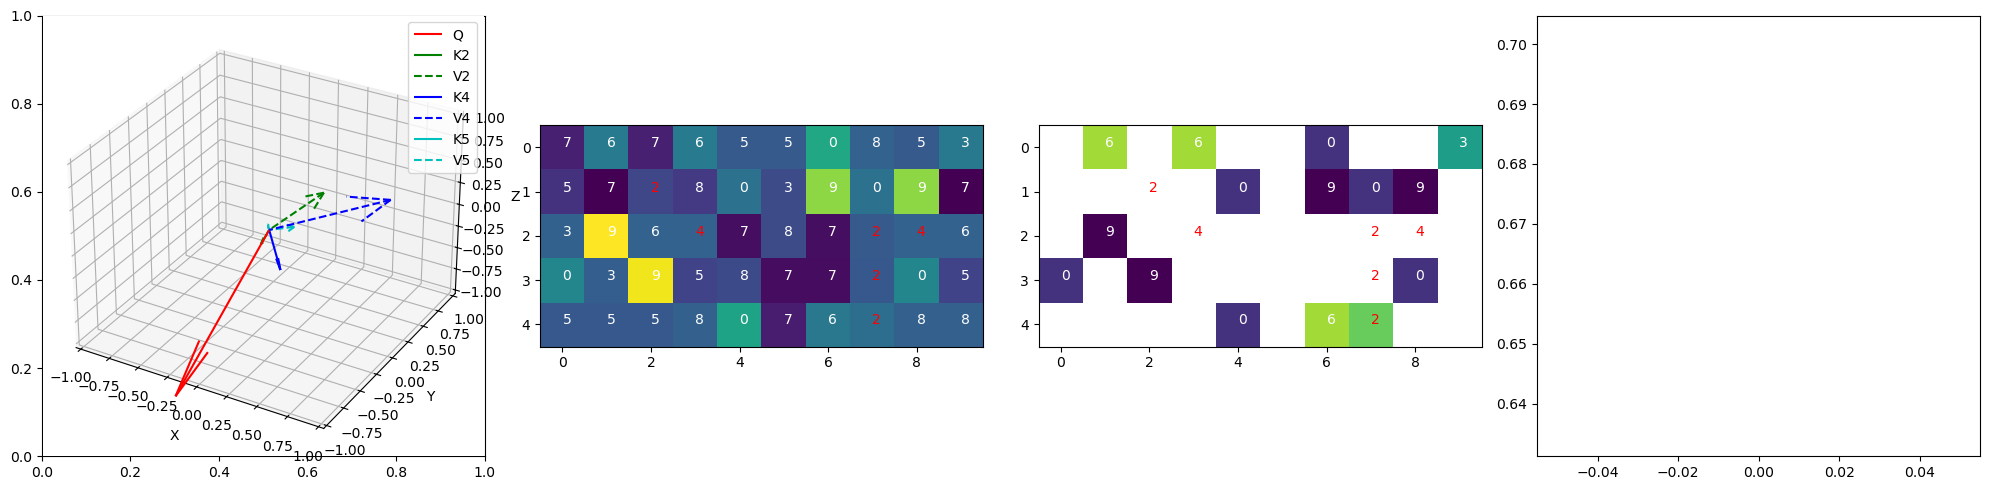

0 0.6680133938789368


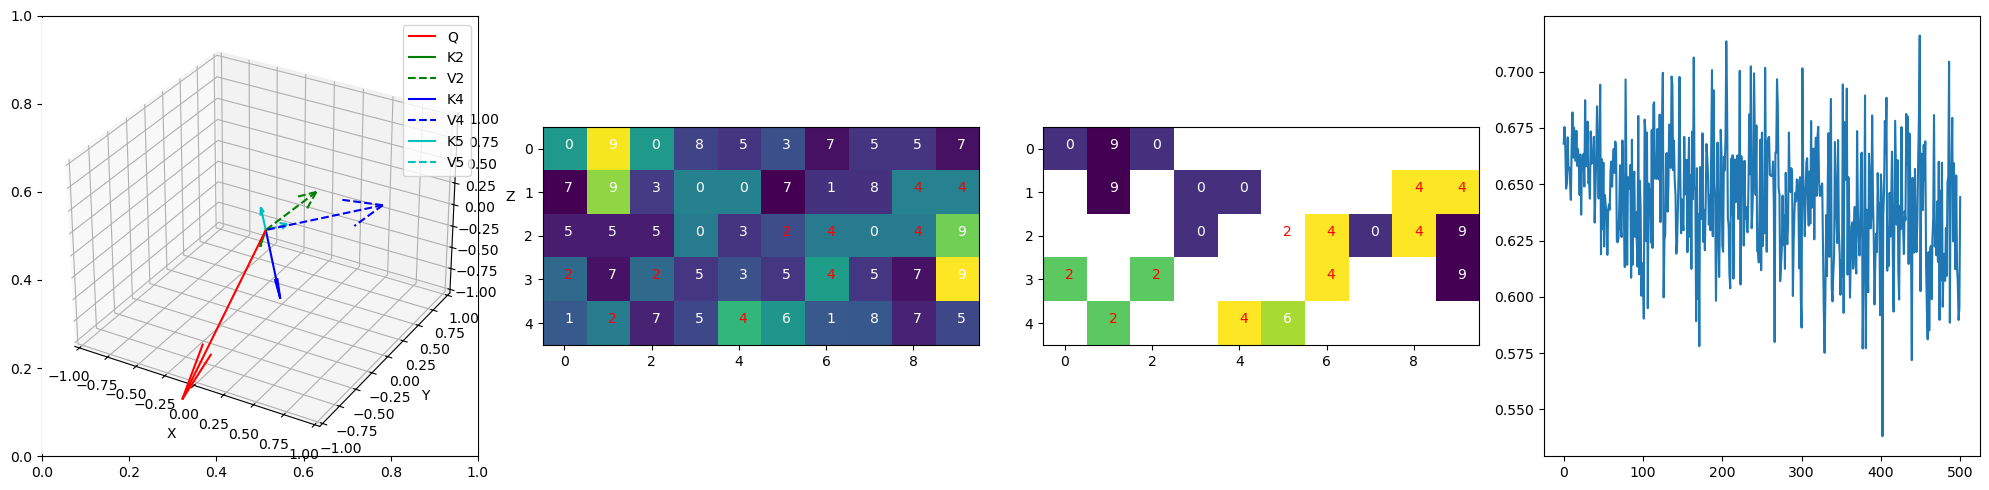

500 0.6442919969558716


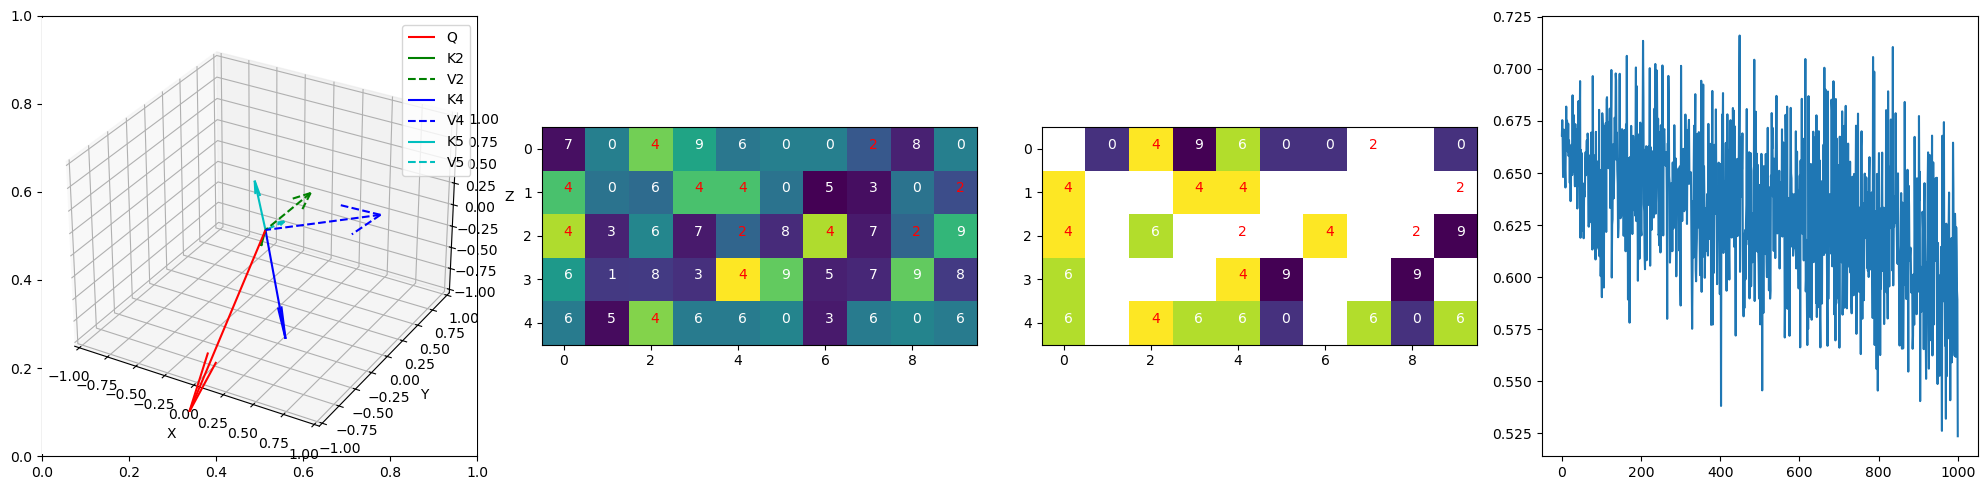

1000 0.5235417485237122


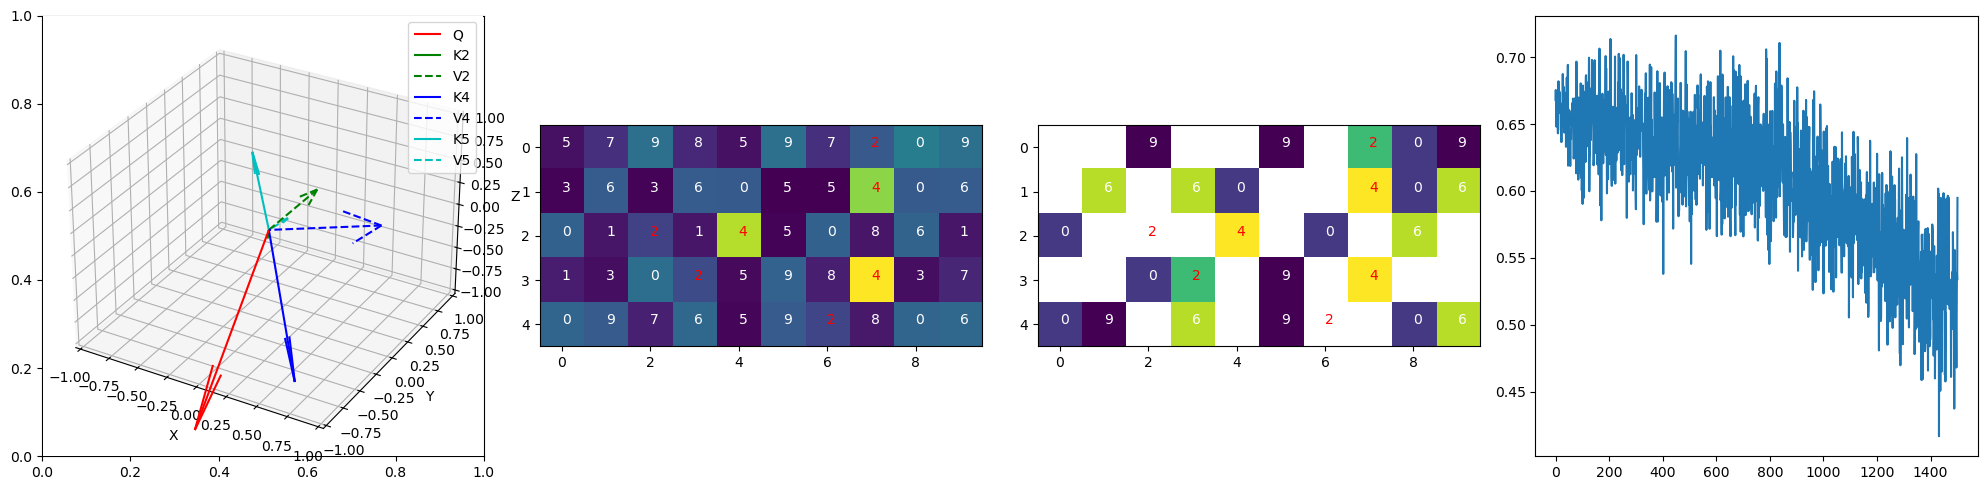

1500 0.5948261618614197


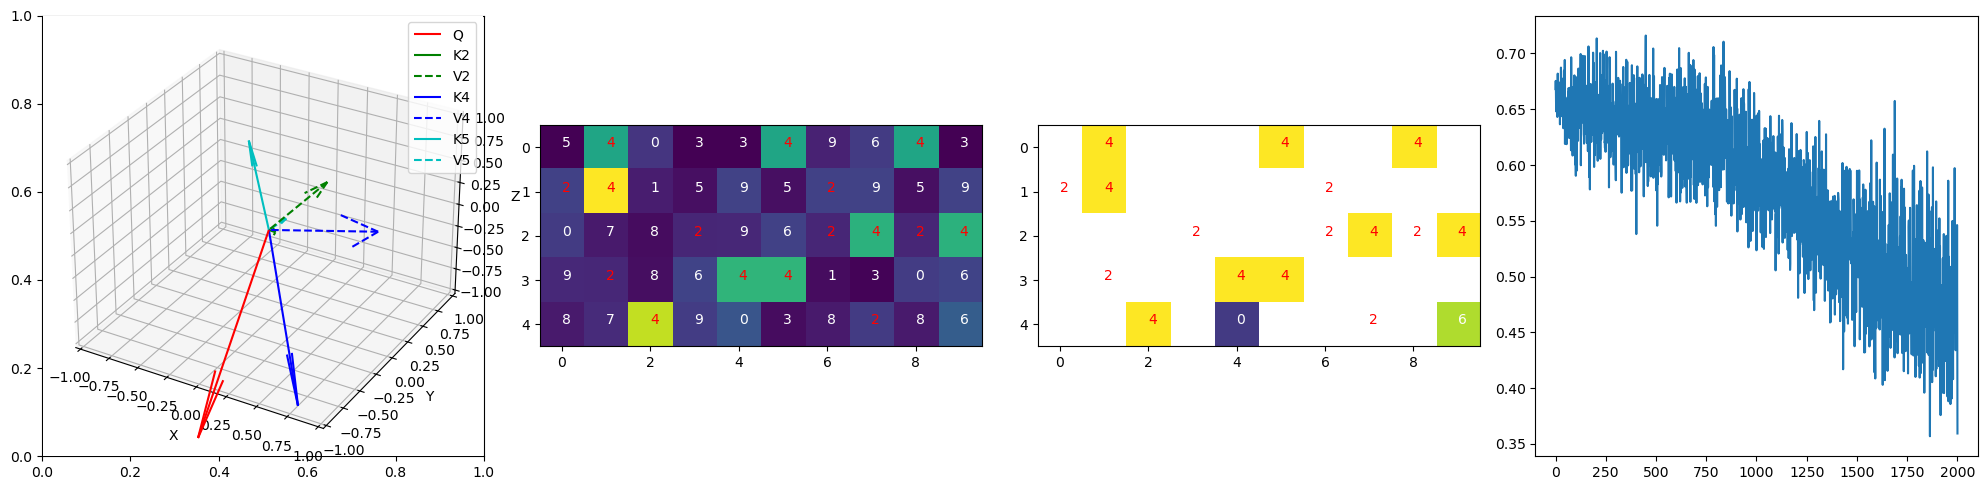

2000 0.3593401312828064


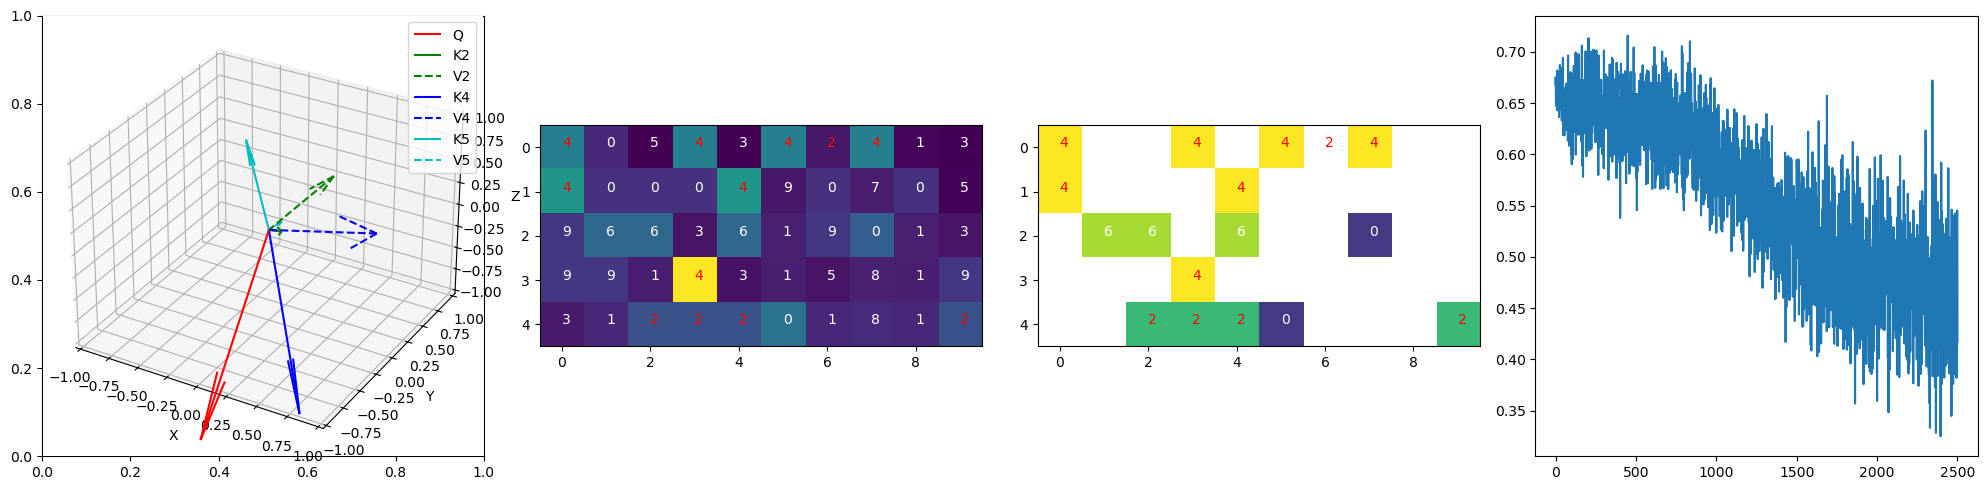

2500 0.41726386547088623


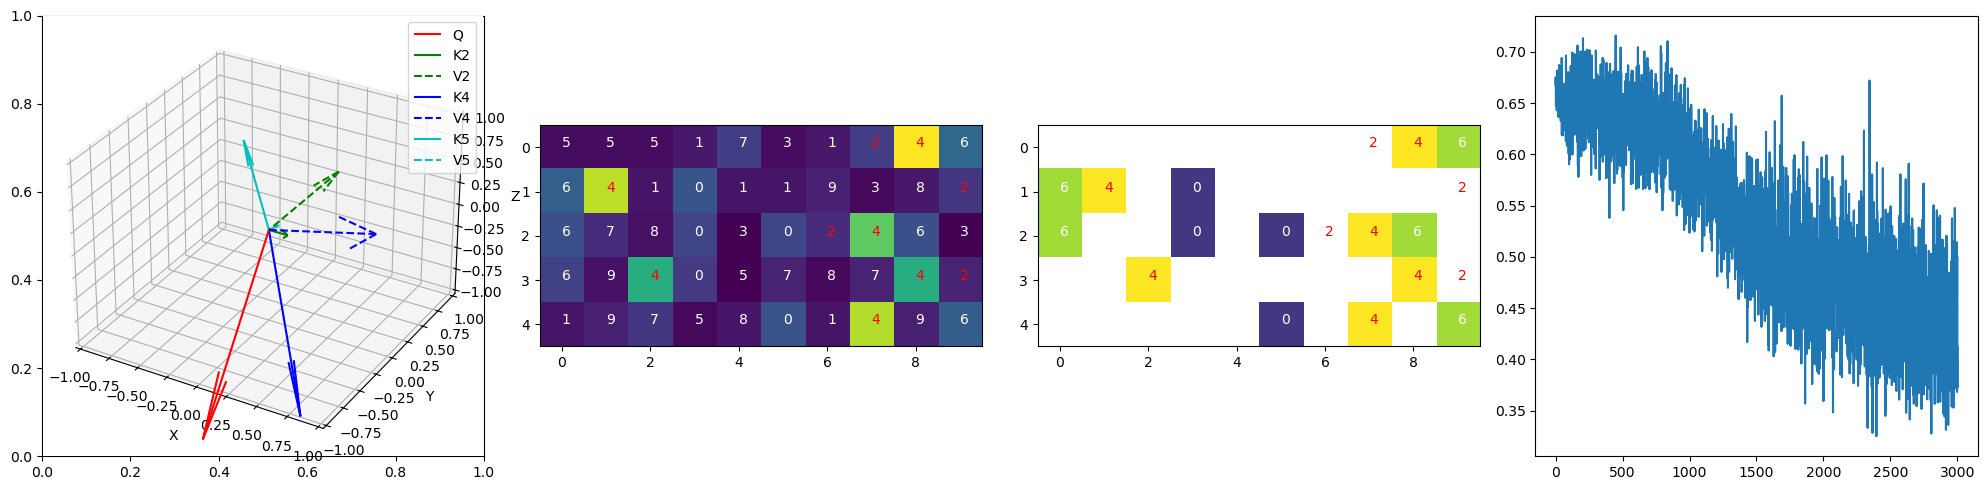

3000 0.4992723762989044


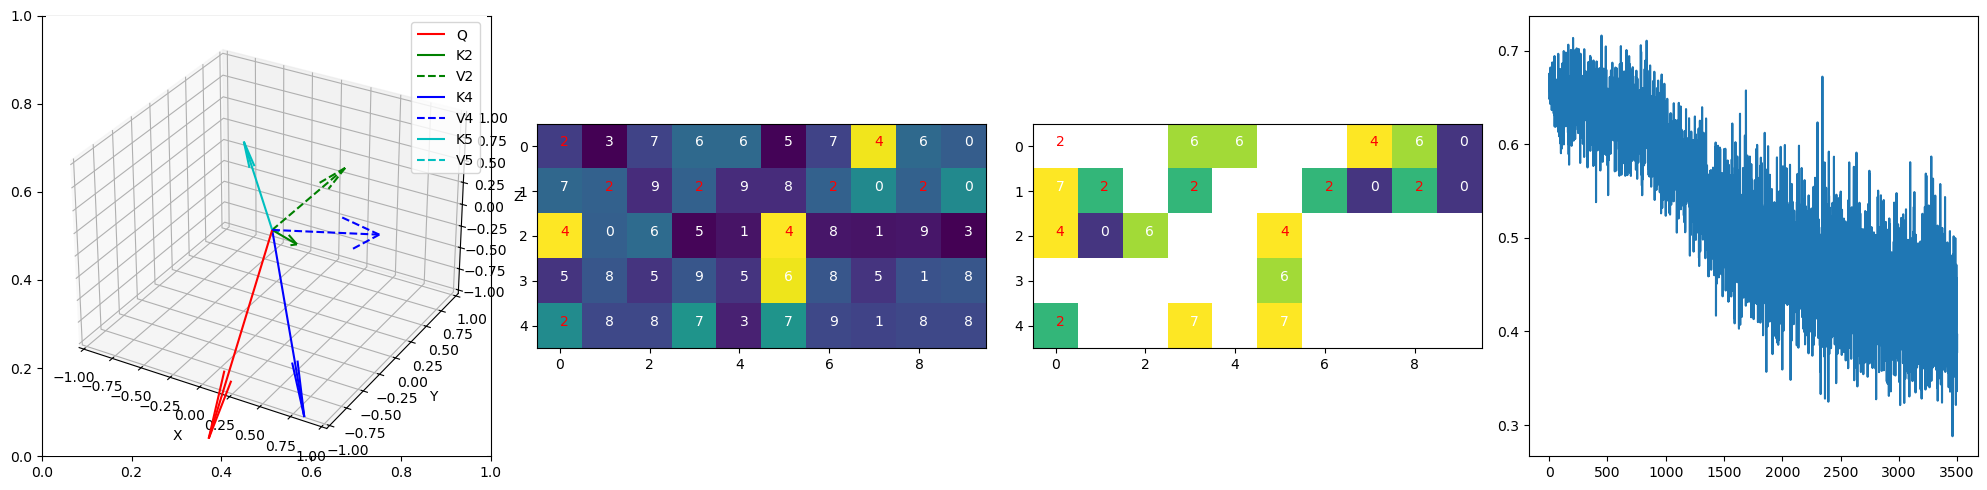

3500 0.396406352519989


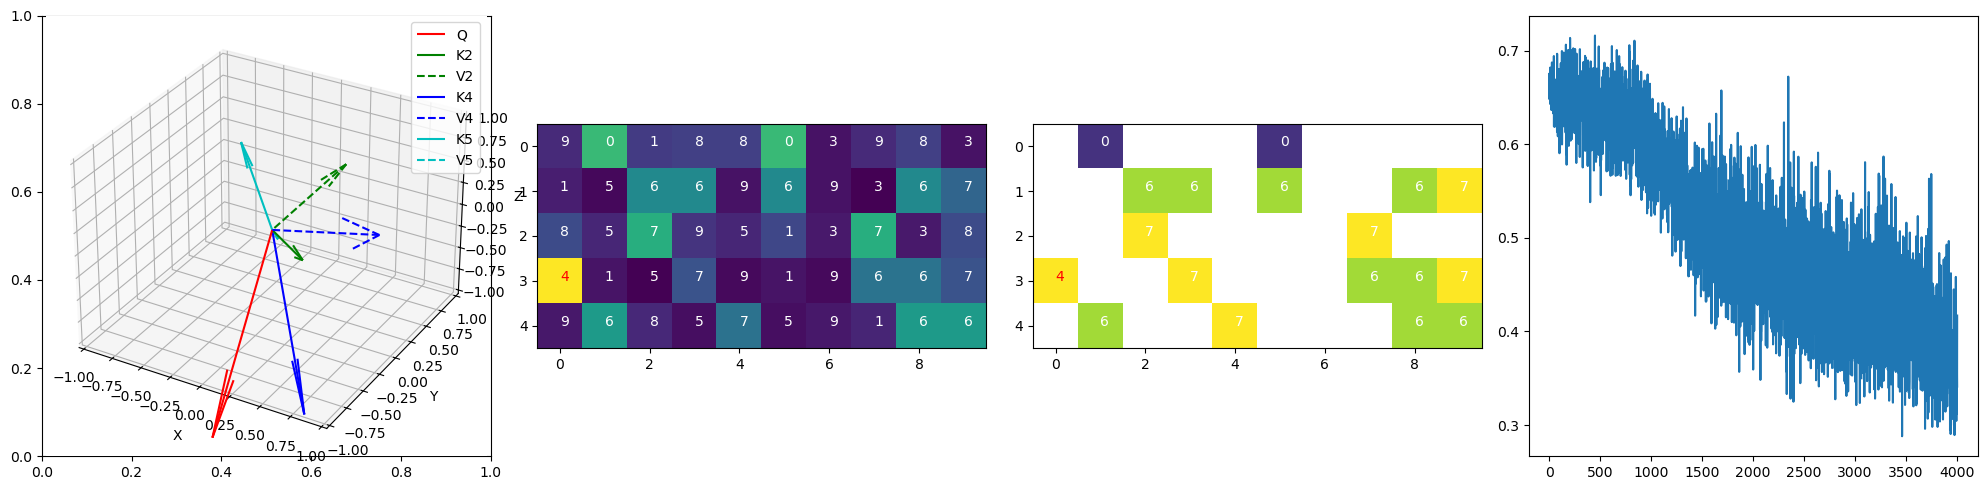

4000 0.4170055091381073


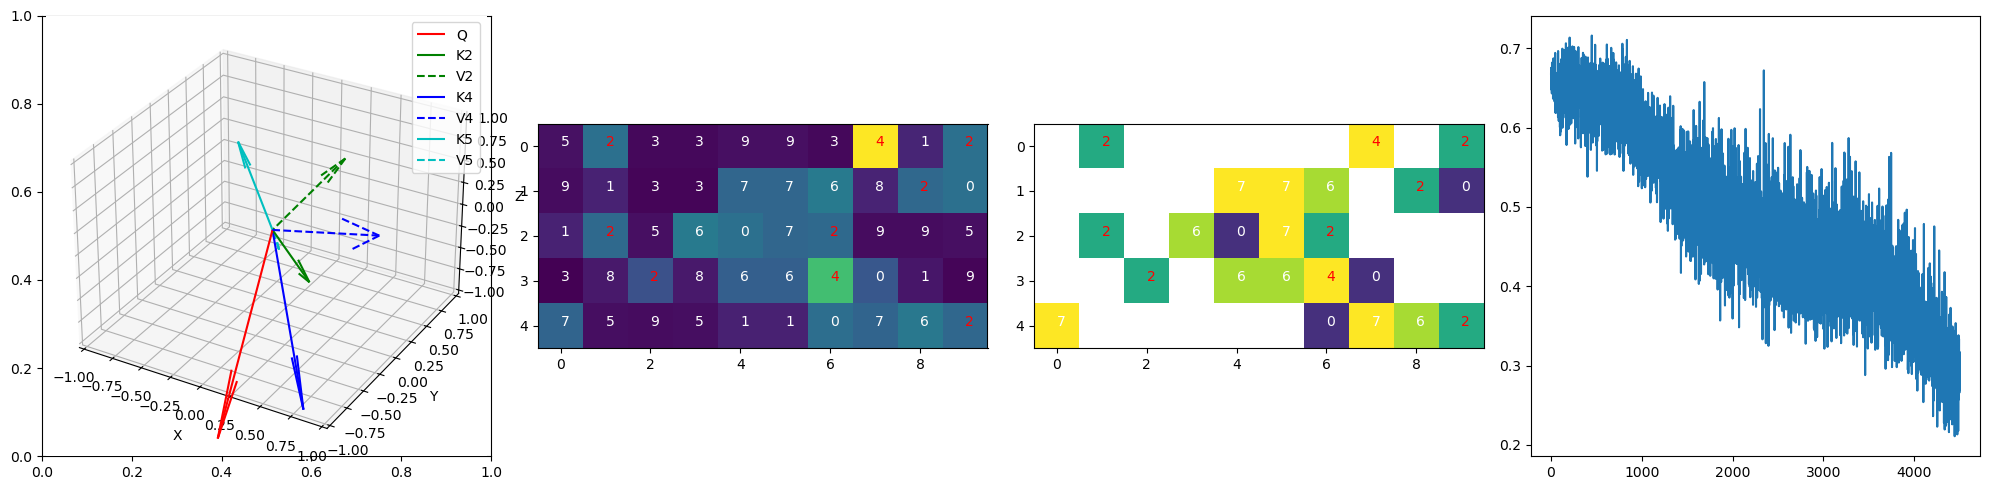

4500 0.28165027499198914


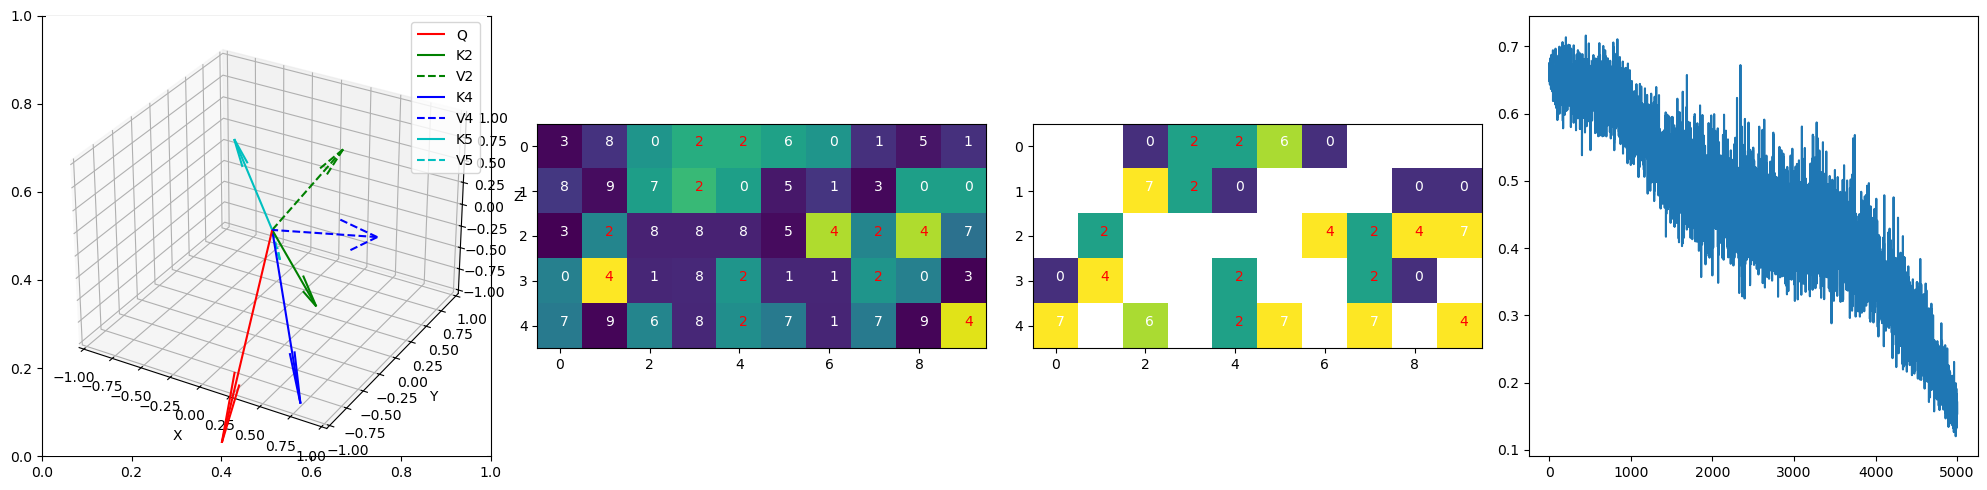

5000 0.15387101471424103


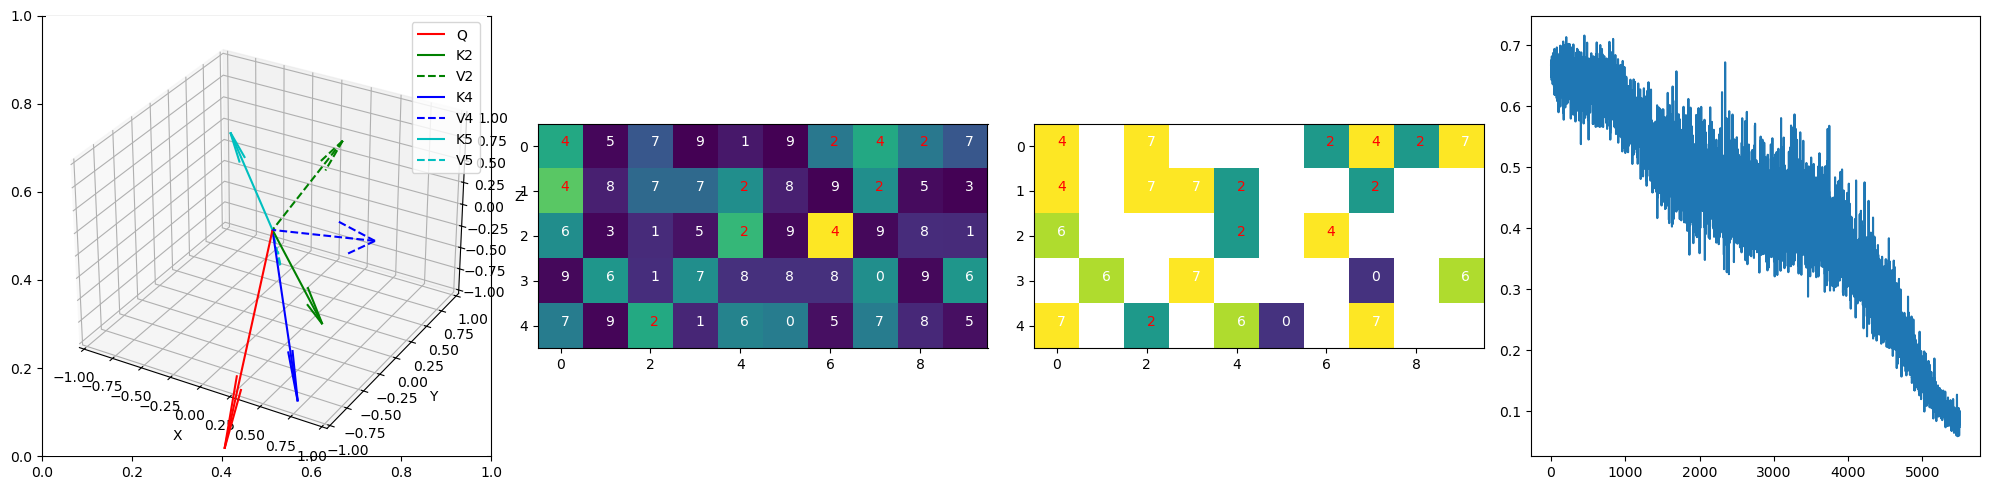

5500 0.07471000403165817


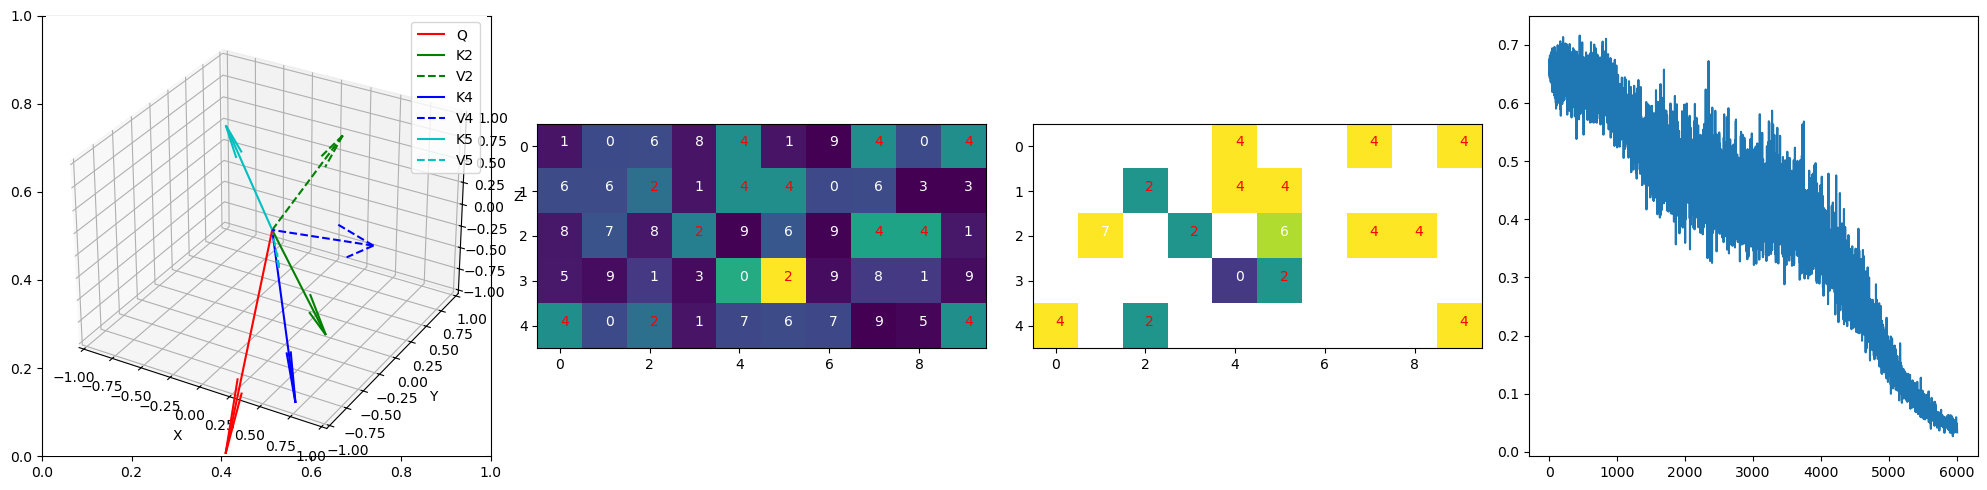

6000 0.033510226756334305


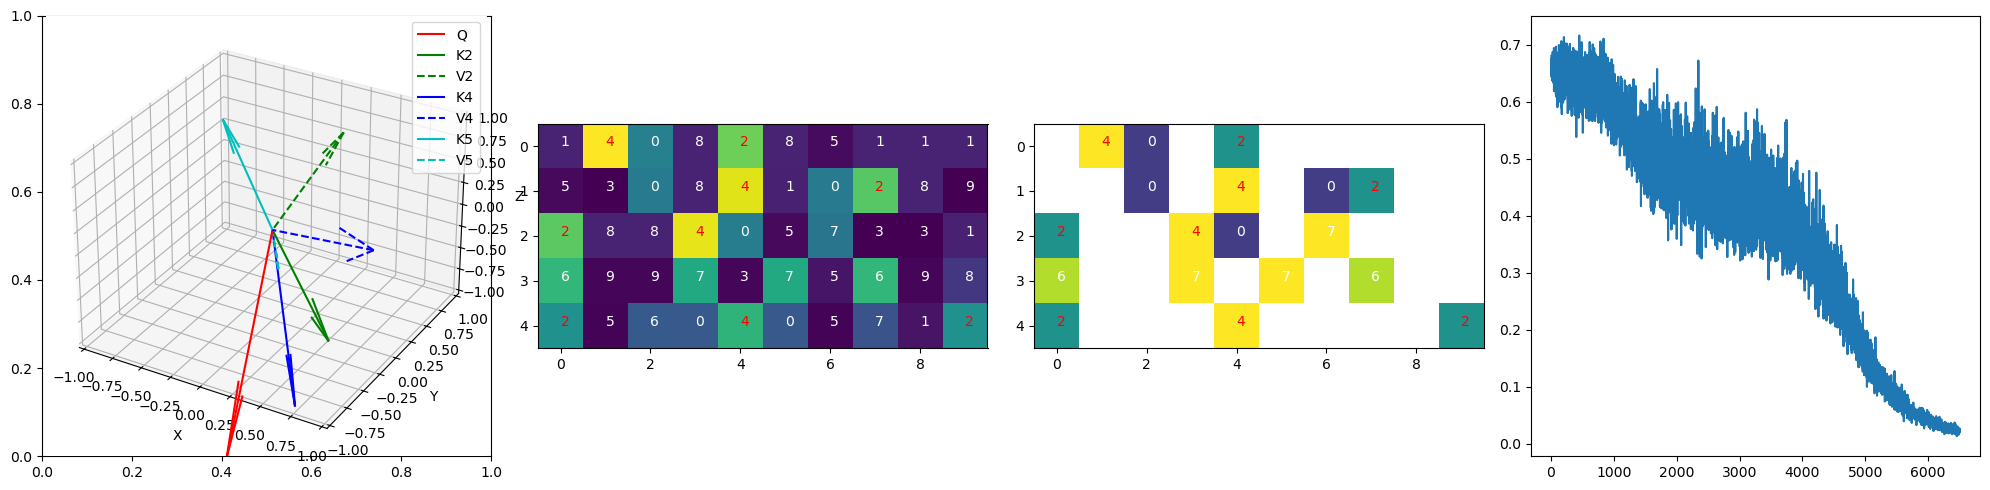

6500 0.021324336528778076


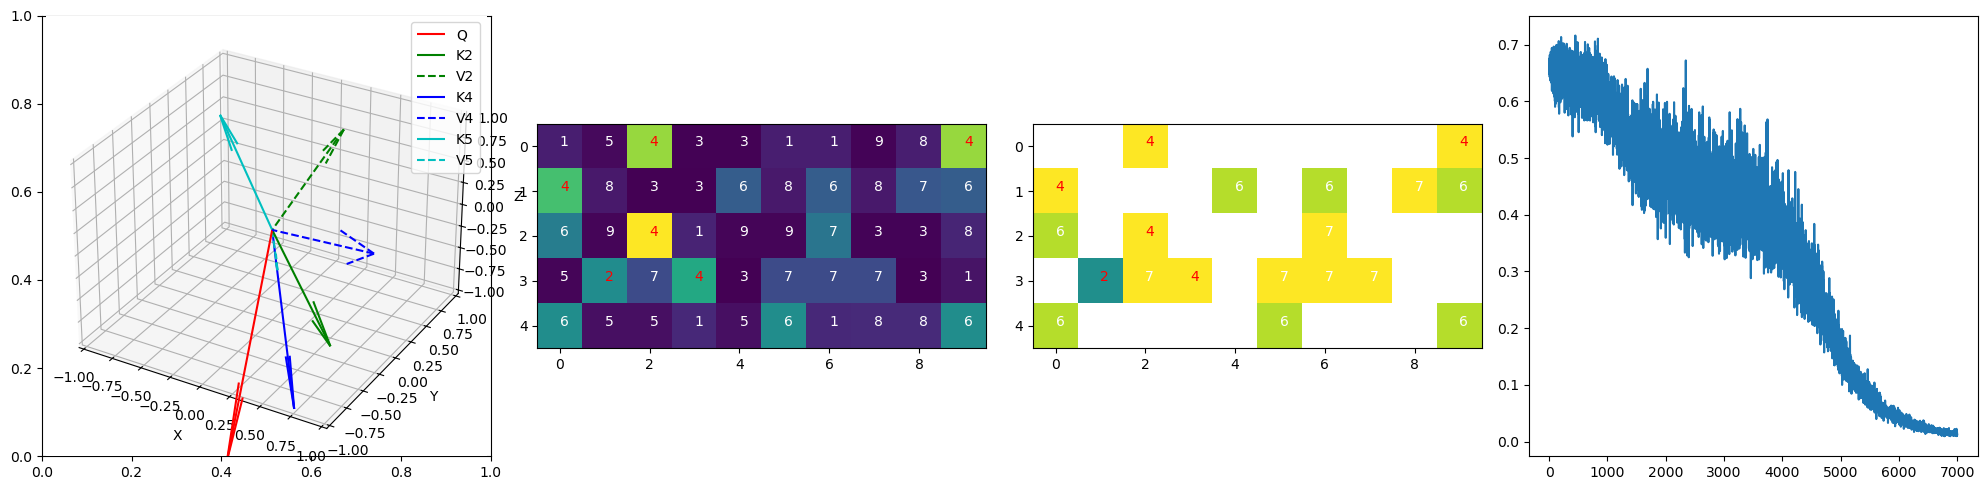

7000 0.012252848595380783


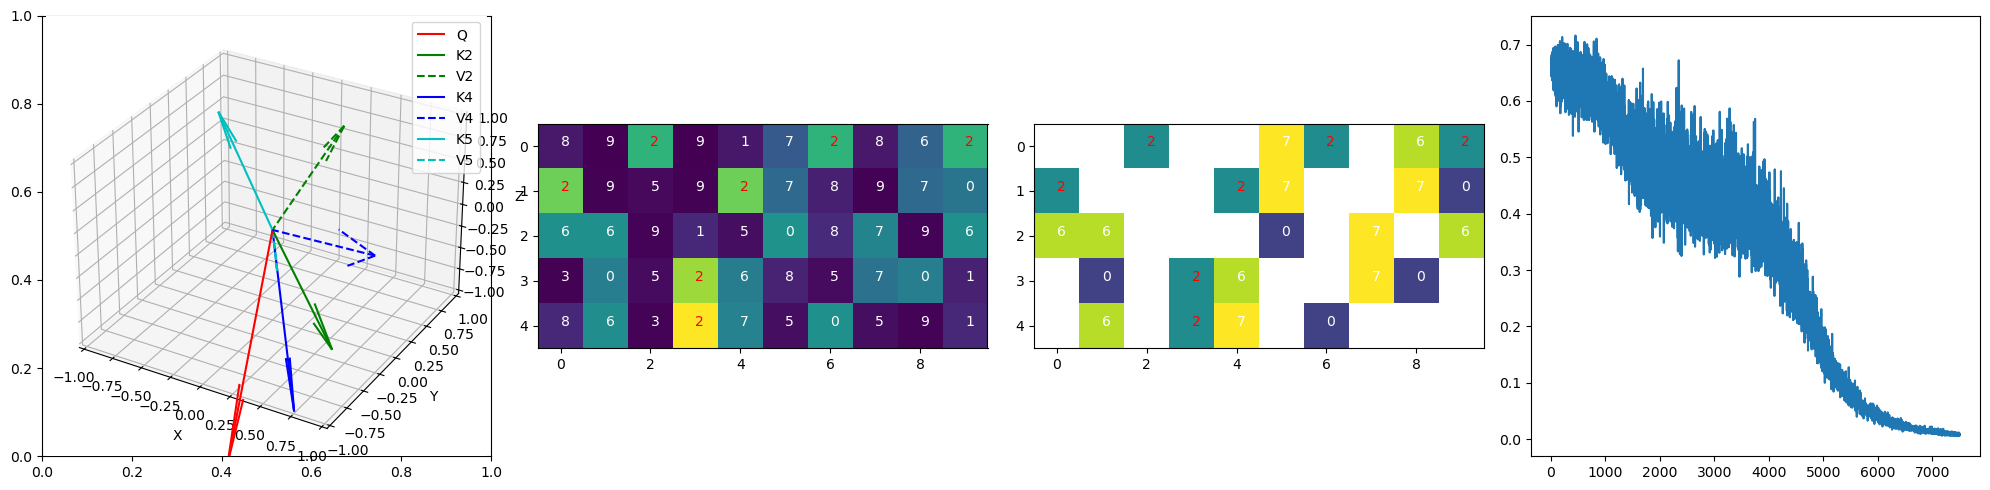

7500 0.008873148821294308


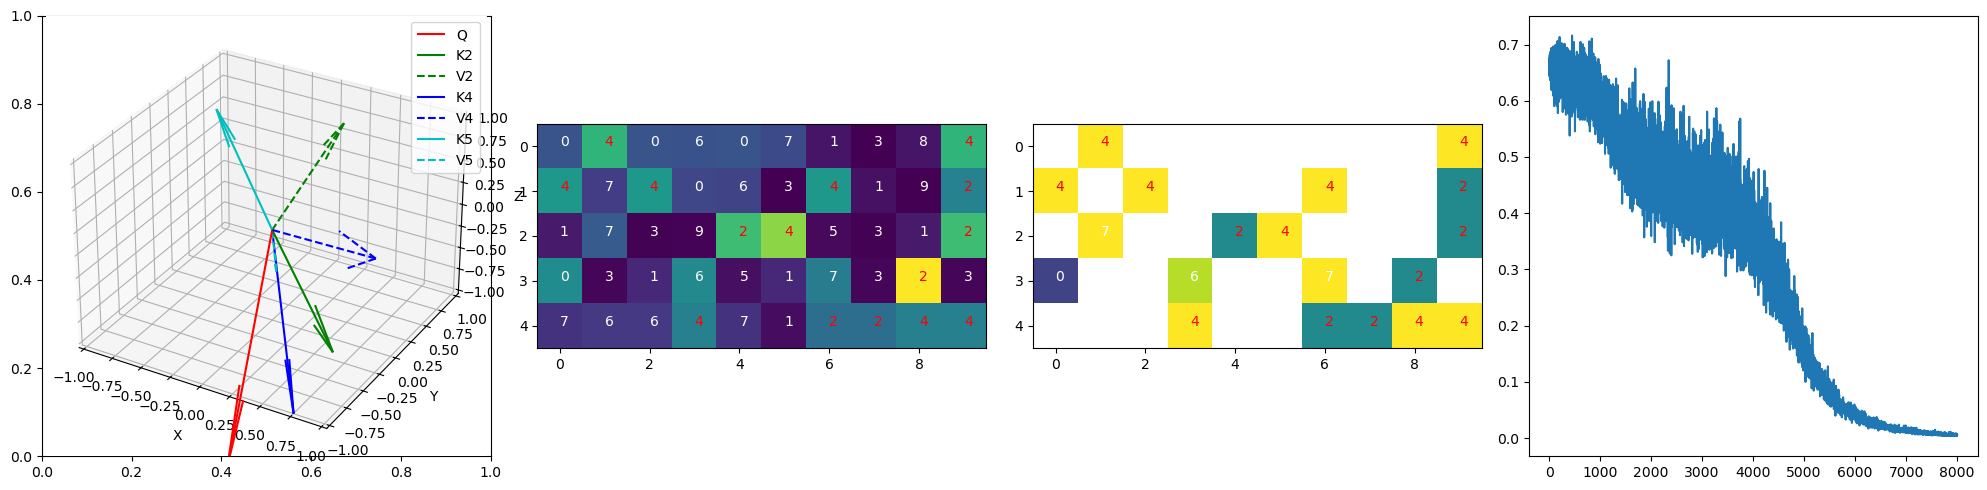

8000 0.005079690366983414


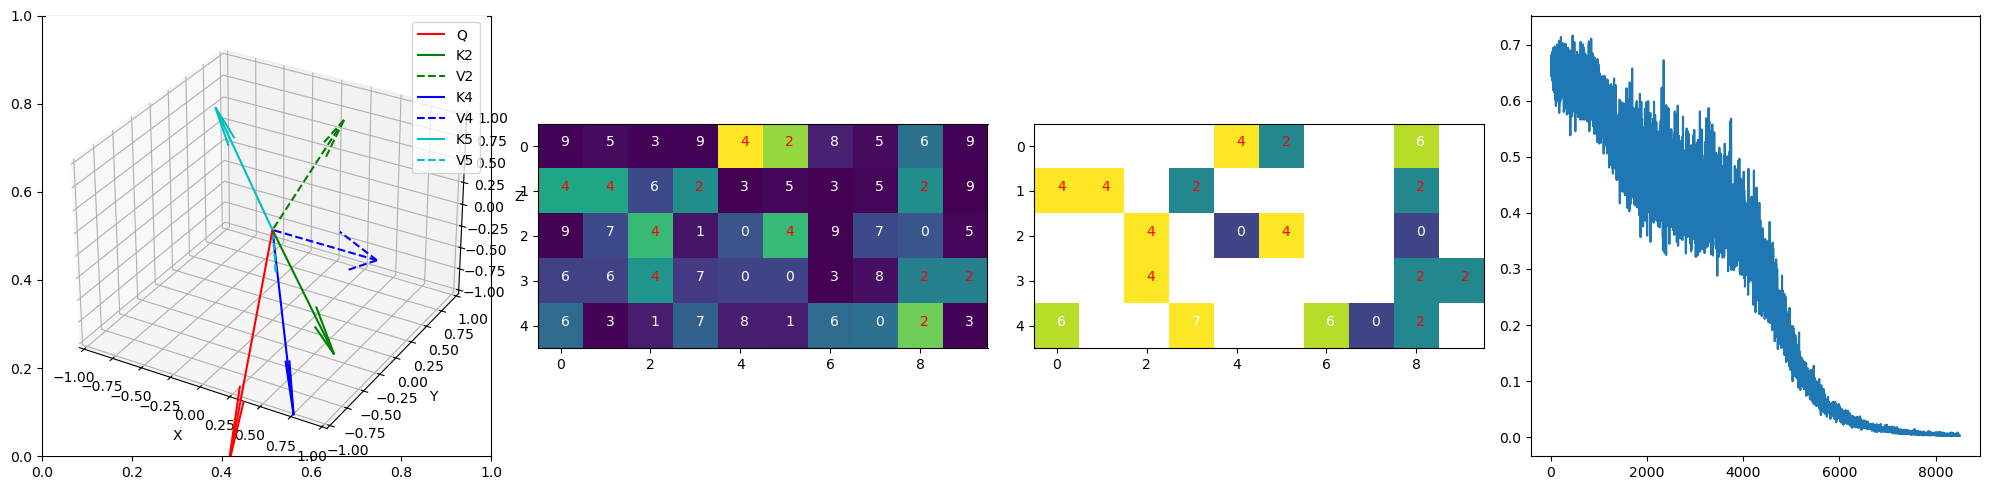

8500 0.0027151440735906363


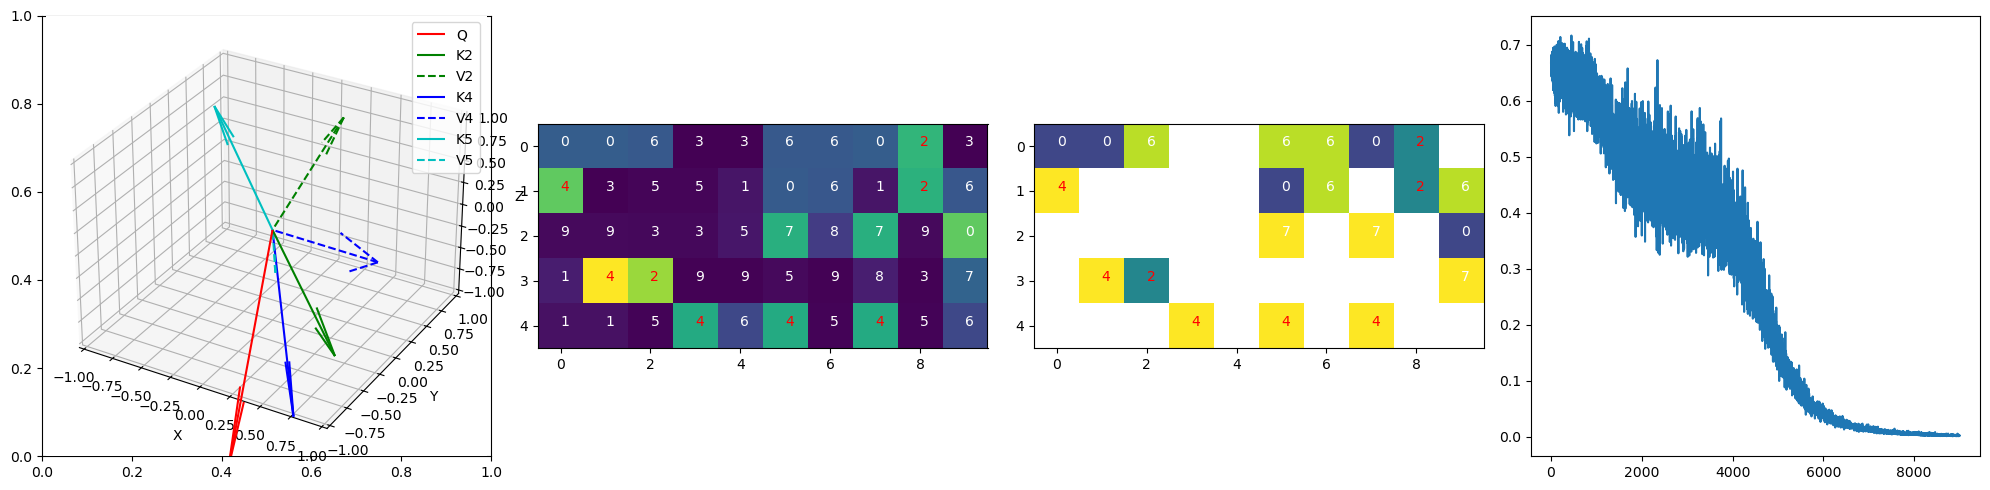

9000 0.0019360100850462914


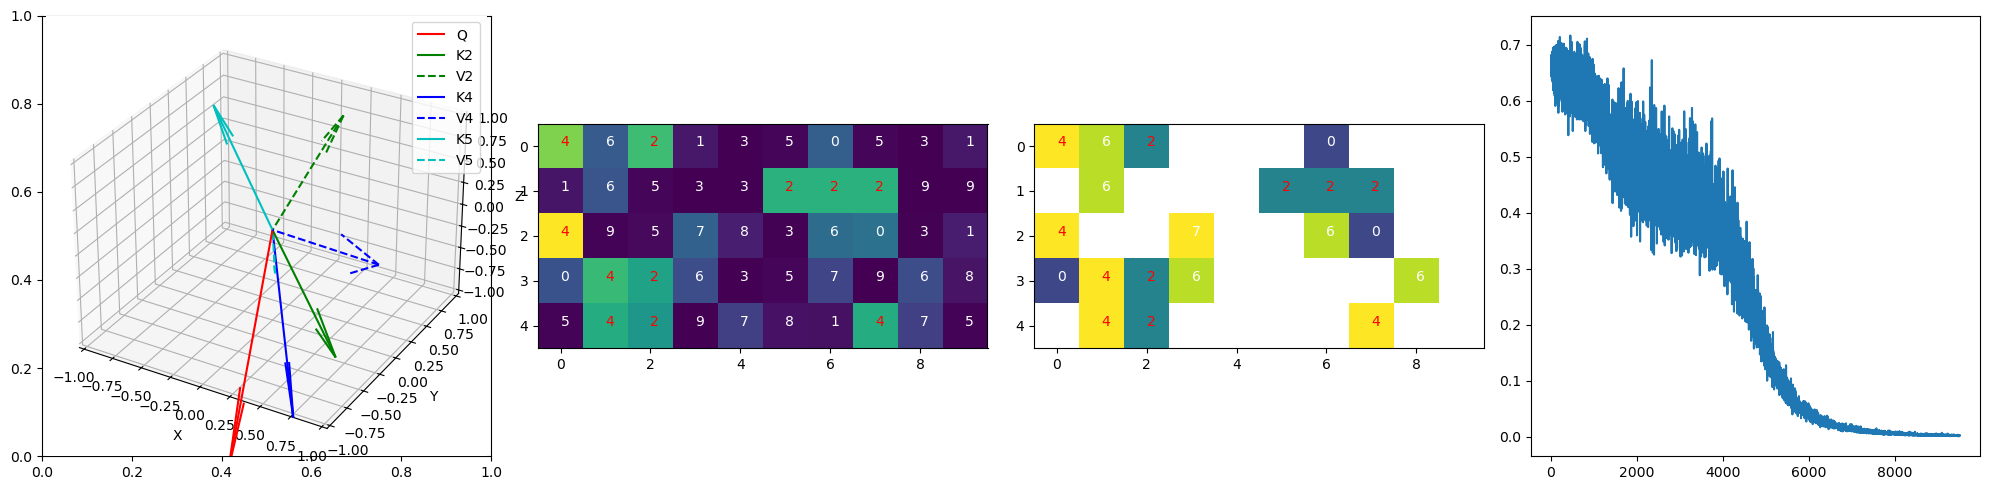

9500 0.002276619430631399


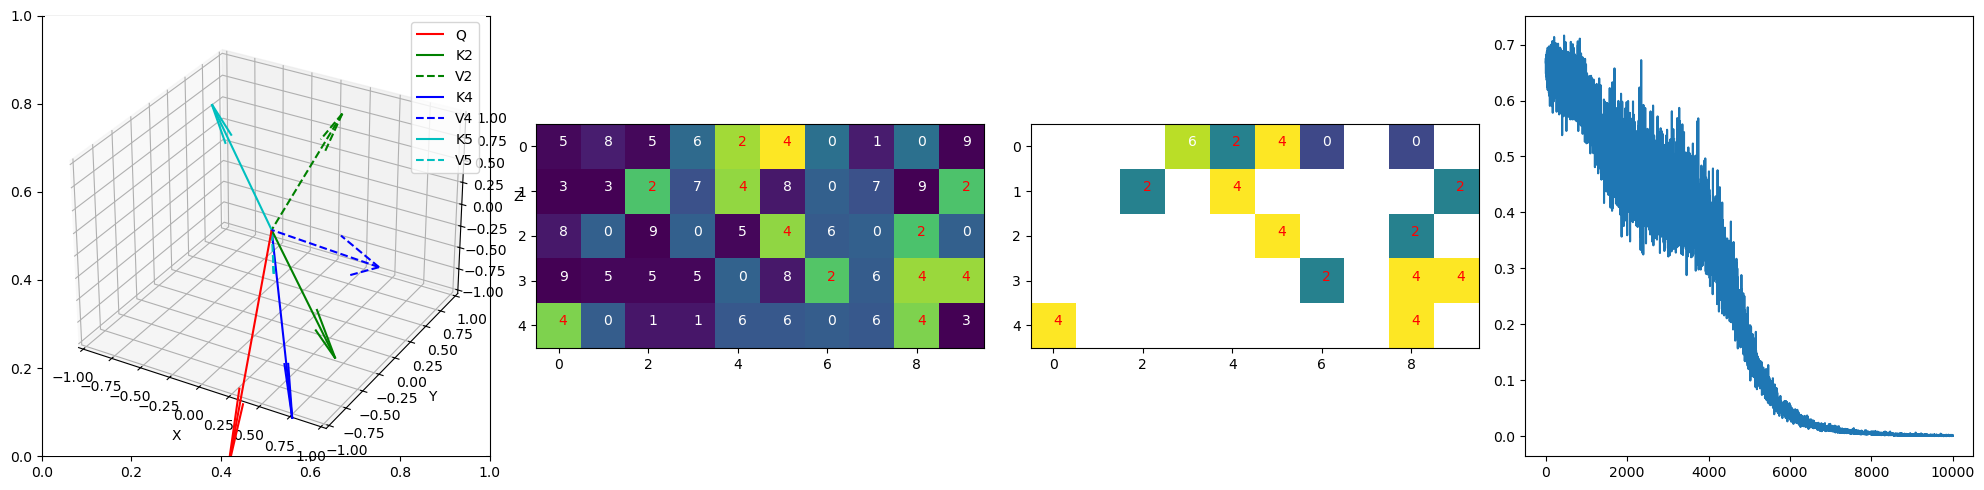

10000 0.001672439742833376


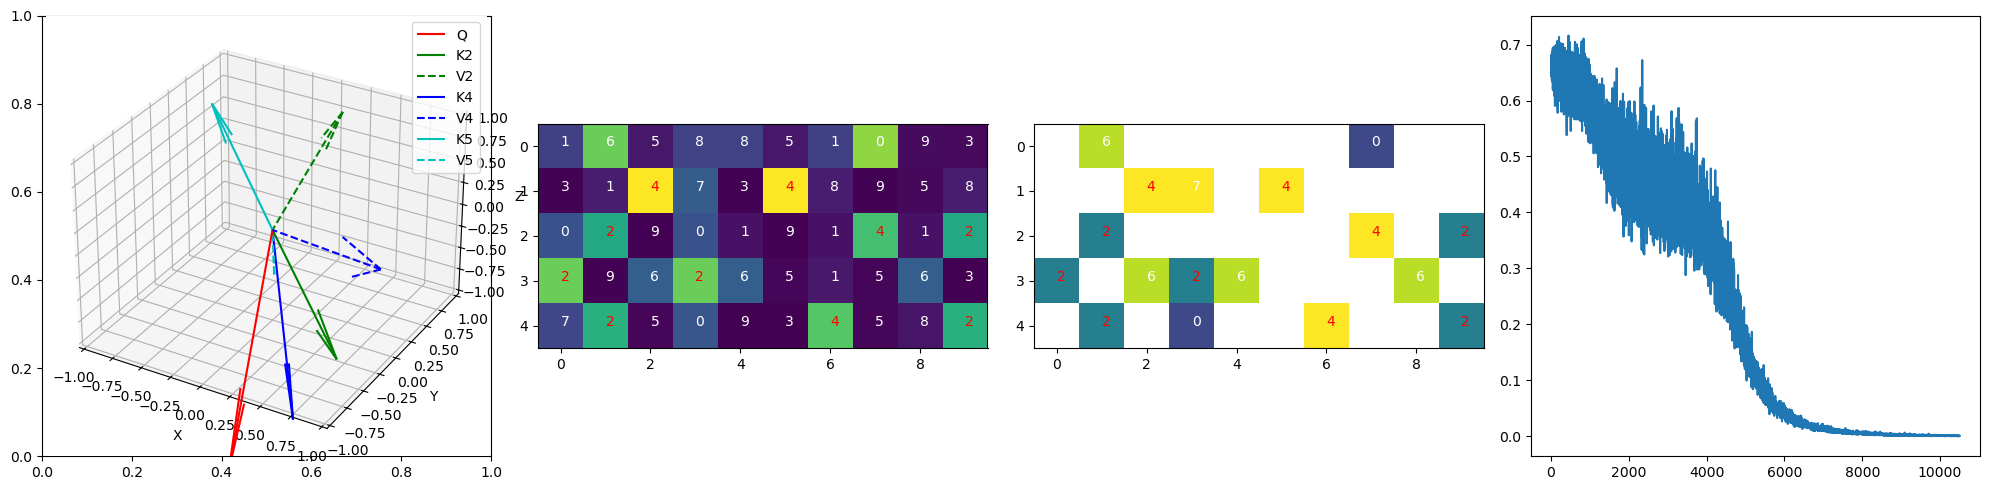

10500 0.0008303991635330021


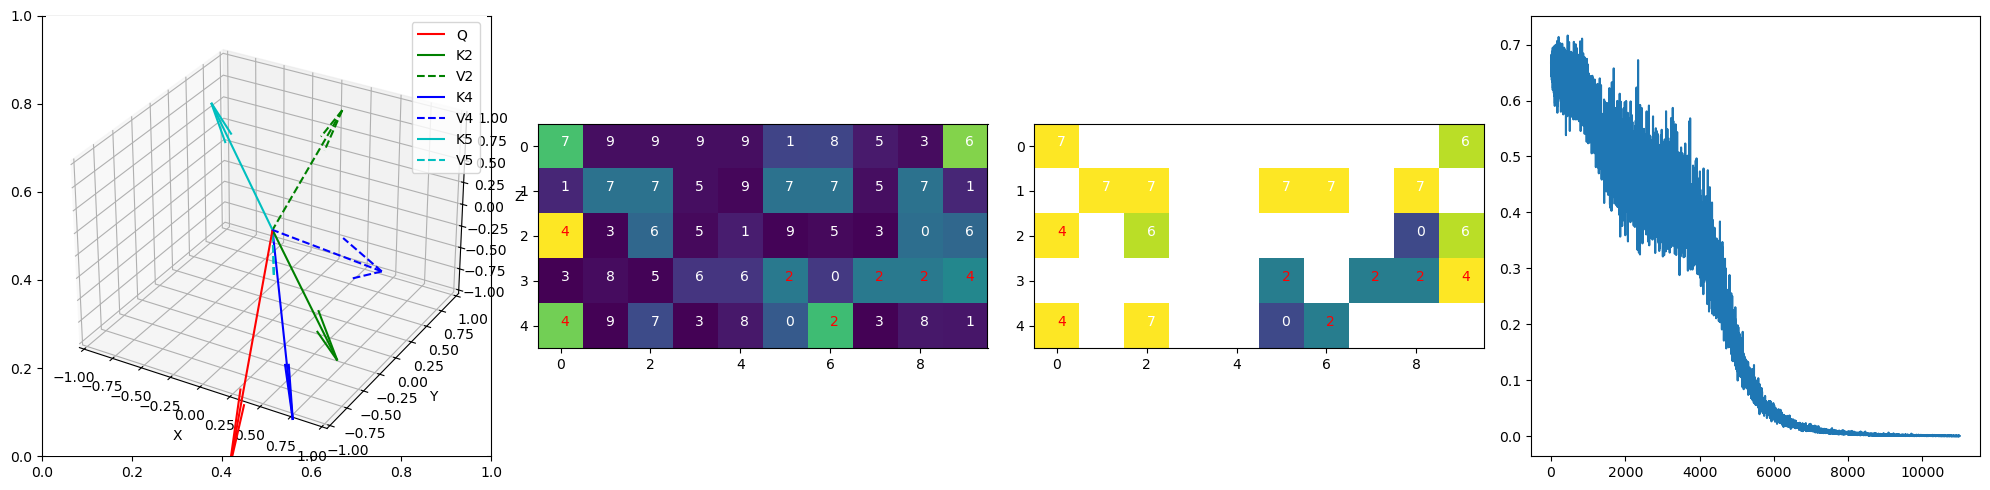

11000 0.0007965147378854454


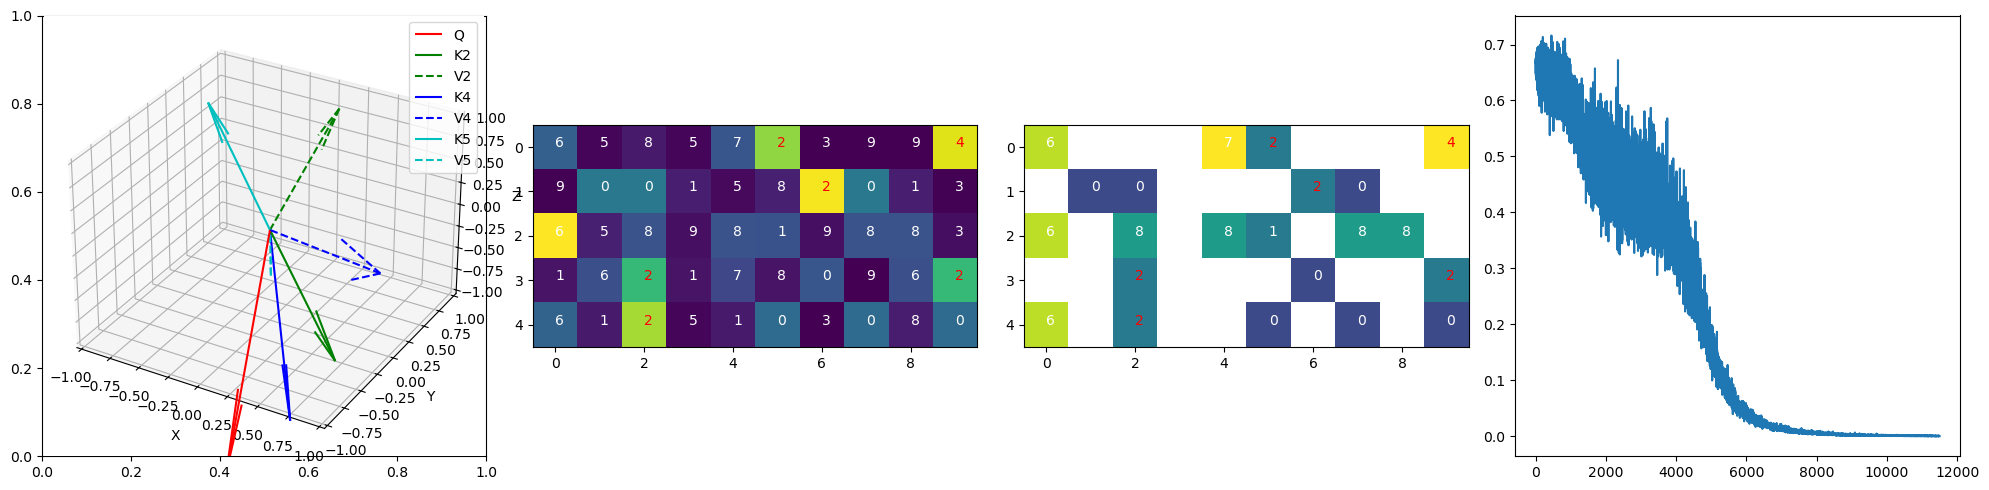

11500 0.00033690917189233005


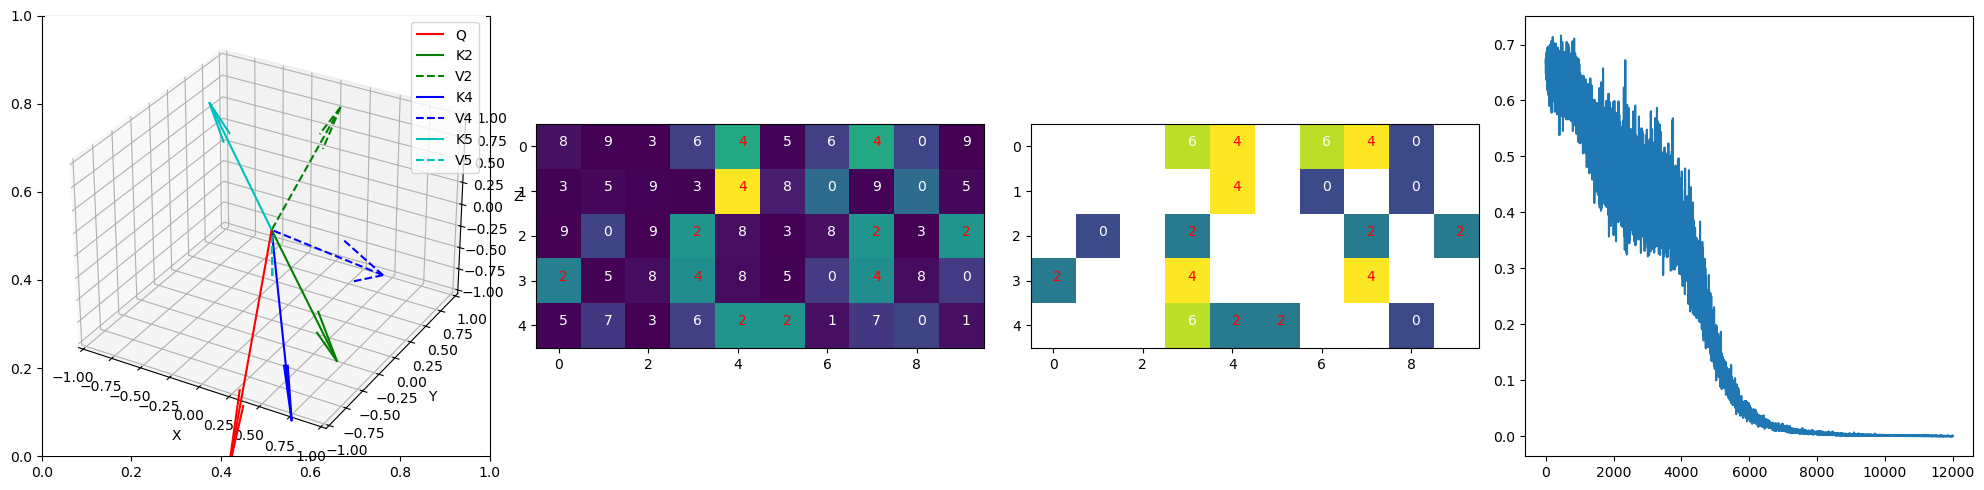

12000 0.0006395949167199433


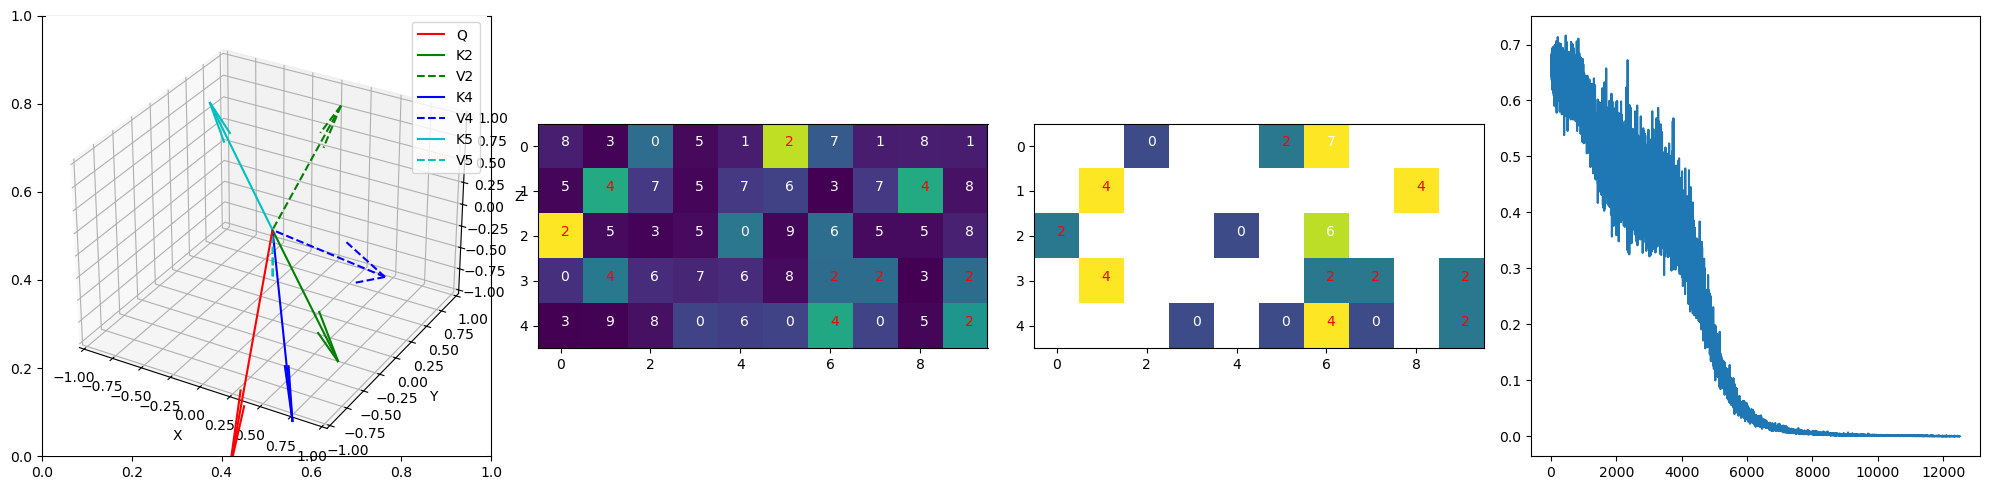

12500 0.00017521575500722975


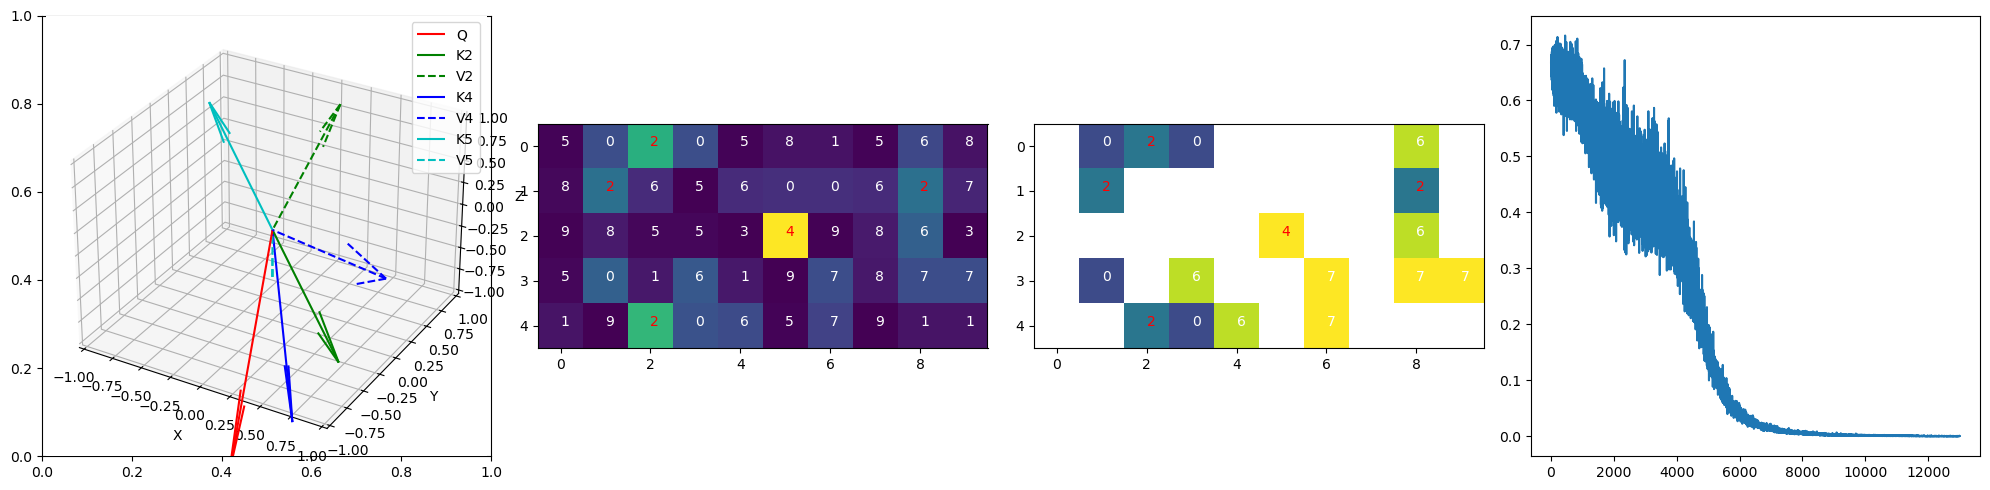

13000 0.00026627659099176526


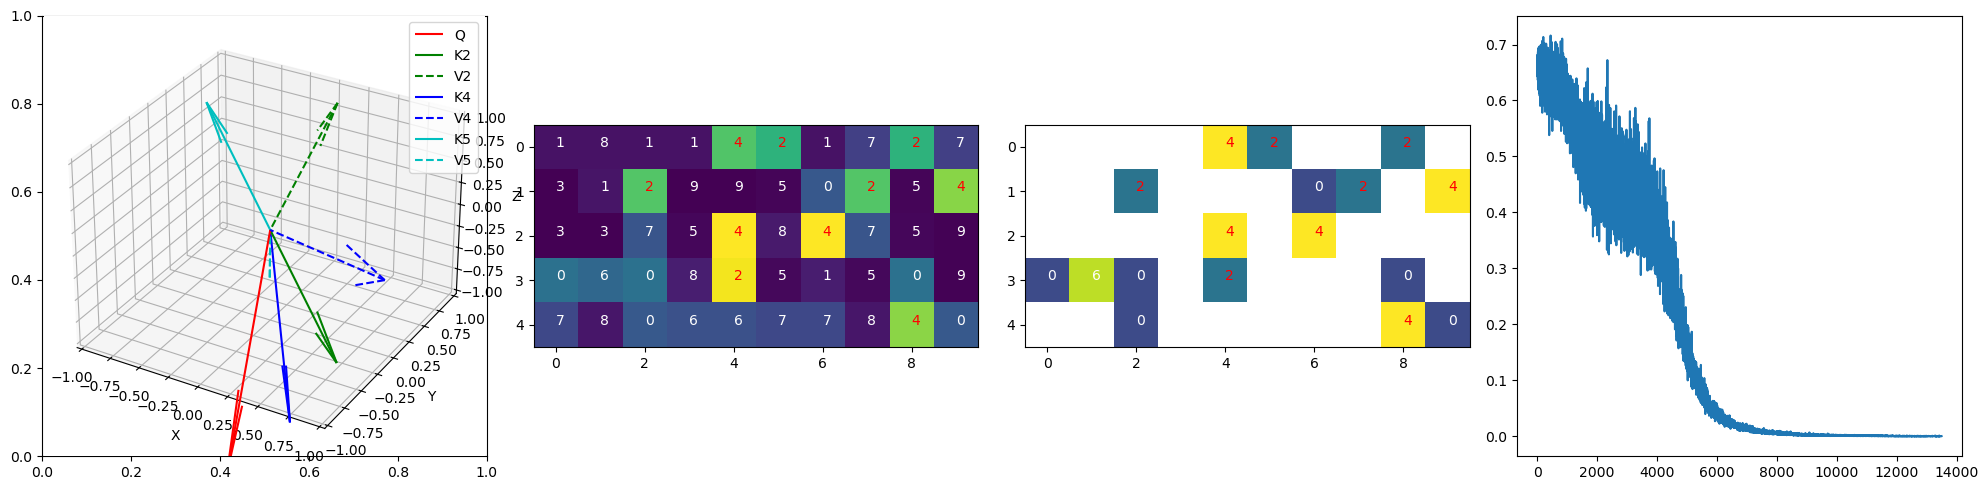

13500 0.0001893334701890126


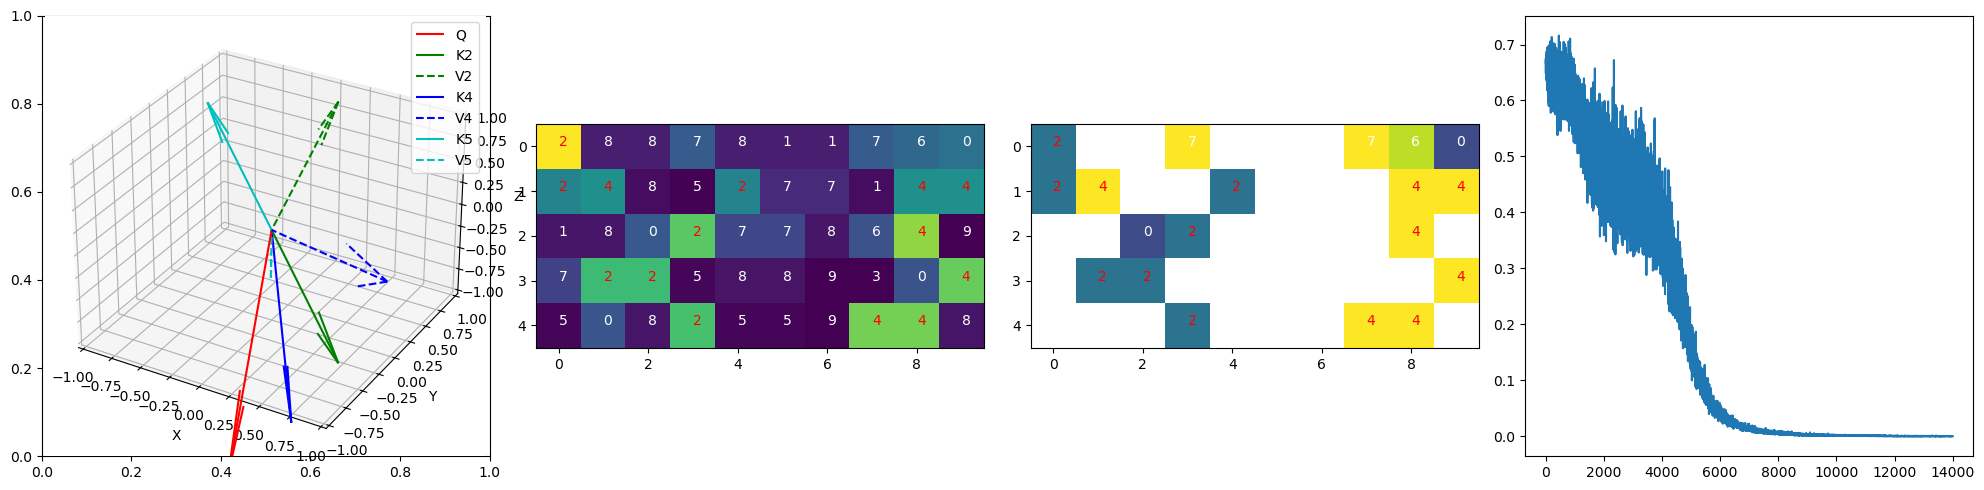

14000 4.640783299691975e-05


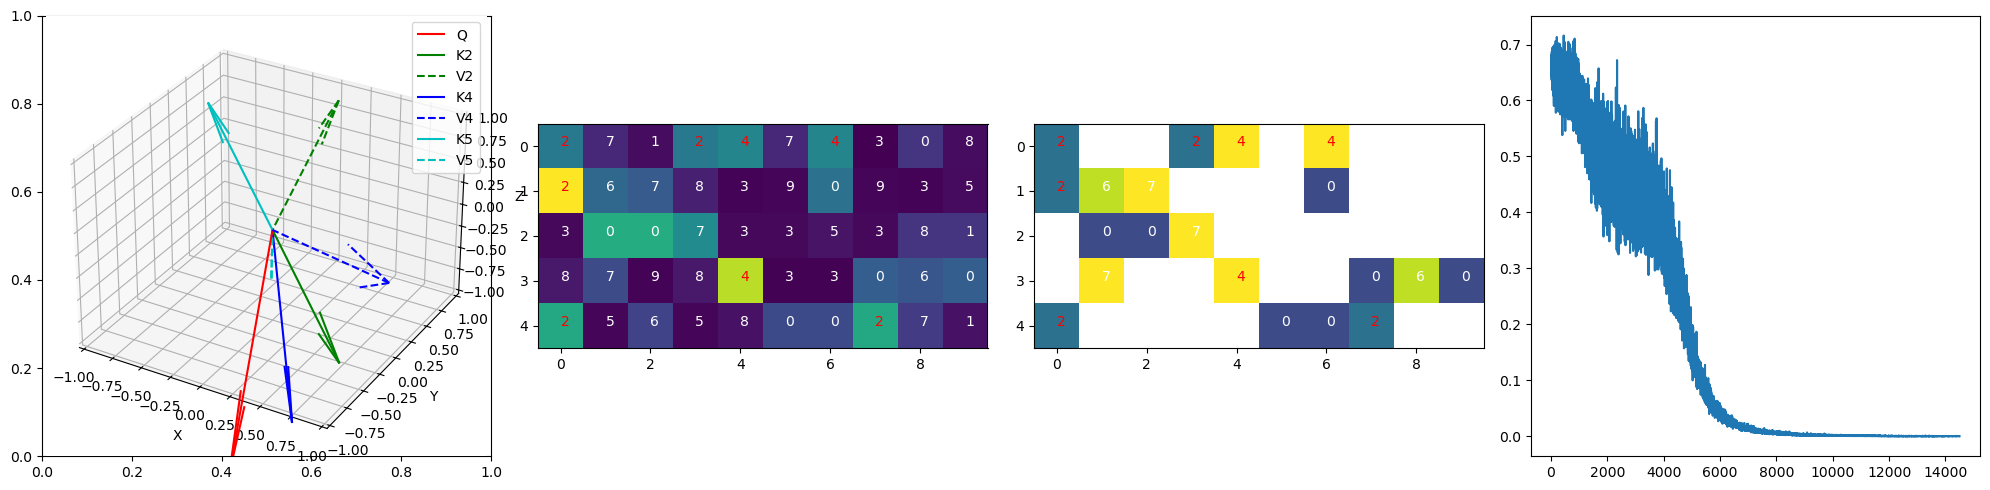

14500 9.344458521809429e-05


[0.6680133938789368,
 0.6754028797149658,
 0.6661482453346252,
 0.6480641961097717,
 0.6504865884780884,
 0.6708526611328125,
 0.6564360857009888,
 0.6574023962020874,
 0.6500438451766968,
 0.6430451273918152,
 0.6678804159164429,
 0.6819109320640564,
 0.6618316173553467,
 0.6751781702041626,
 0.6708587408065796,
 0.6603949069976807,
 0.673713207244873,
 0.658165454864502,
 0.6656835079193115,
 0.6605585217475891,
 0.6452476382255554,
 0.6632260680198669,
 0.6364925503730774,
 0.6612374186515808,
 0.6590533256530762,
 0.663533627986908,
 0.6490232944488525,
 0.6873320937156677,
 0.6580134630203247,
 0.6604382991790771,
 0.6778431534767151,
 0.6504504680633545,
 0.6514650583267212,
 0.6436160802841187,
 0.6734962463378906,
 0.6590979099273682,
 0.659574031829834,
 0.6620030999183655,
 0.6711295247077942,
 0.6329535841941833,
 0.6462963223457336,
 0.6633851528167725,
 0.684602677822113,
 0.6630538702011108,
 0.6436949372291565,
 0.6666228771209717,
 0.6941682696342468,
 0.618901491165161

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class AttentionModel(nn.Module):
    def __init__(self):
        super(AttentionModel, self).__init__()
        self.embed_dim = 3
        self.att_dim = 3
        self.embed = nn.Embedding(10, self.embed_dim)
        
        # one query
        self.query = nn.Parameter(torch.randn(1, self.att_dim))
        
        # used to compute keys
        self.WK = nn.Linear(self.embed_dim, self.att_dim)
        
        # used to compute values
        self.WV = nn.Linear(self.embed_dim, 3)
        
        # final decision based on attention-weighted value
        self.nn = nn.Sequential(
            nn.Linear(3, 200),
            nn.ReLU(),
            nn.Linear(200, 1),
            nn.Sigmoid(),
        )

    def attention(self, x):
        queries = self.query
        keys = self.WK(x)
        qk = torch.einsum('ik,bjk->bij', queries, keys)
        att = torch.softmax(qk / (self.att_dim ** 0.5), dim=-1)
        return att
    
    def values(self, x):
        return self.WV(x)

    def forward(self, x):
        x = self.embed(x)
        att = self.attention(x)
        values = self.values(x)
        aggreg = torch.einsum('bij,bjk->bik', att, values)
        mlp_result = self.nn(aggreg[:, 0, :])
        return mlp_result

def plot_vec(ax, Q, K2, V2, K4, V4, K5, V5):
    # Plot the vectors for number 2
    ax.quiver(0, 0, 0, Q[0], Q[1], Q[2], color='r', label='Q')
    ax.quiver(0, 0, 0, K2[0], K2[1], K2[2], color='g', label='K2')
    ax.quiver(0, 0, 0, V2[0], V2[1], V2[2], color='g', linestyle='--', label='V2')

    # Plot the vectors for number 4
    ax.quiver(0, 0, 0, K4[0], K4[1], K4[2], color='b', label='K4')
    ax.quiver(0, 0, 0, V4[0], V4[1], V4[2], color='b', linestyle='--', label='V4')

    # Plot the vectors for number 5
    ax.quiver(0, 0, 0, K5[0], K5[1], K5[2], color='c', label='K5')
    ax.quiver(0, 0, 0, V5[0], V5[1], V5[2], color='c', linestyle='--', label='V5')

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add legend
    ax.legend()

    # Set the limits of the plot
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

def plot_all(model, N, traj, cnt):
    x, y = make_batch(N)
    f, axarr = plt.subplots(1, 4, figsize=(20, 5))
    
    # Plot 3D vectors
    ax3d = f.add_subplot(141, projection='3d')
    with torch.no_grad():
        Q = model.query.numpy()[0]
        embed_2 = model.embed(torch.tensor([2]))
        K2 = model.WK(embed_2).numpy()[0]
        V2 = model.WV(embed_2).numpy()[0]
        embed_4 = model.embed(torch.tensor([4]))
        K4 = model.WK(embed_4).numpy()[0]
        V4 = model.WV(embed_4).numpy()[0]
        embed_5 = model.embed(torch.tensor([5]))
        K5 = model.WK(embed_5).numpy()[0]
        V5 = model.WV(embed_5).numpy()[0]
        plot_vec(ax3d, Q, K2, V2, K4, V4, K5, V5)
    
    # Attention heatmap
    ax = axarr[1]
    at = model.attention(model.embed(x))[:, 0, :].detach().numpy()
    ax.imshow(at)
    
    # Value heatmap
    ax = axarr[2]
    vals = model.values(model.embed(x))[:, :, 0].detach().numpy()
    nan = np.ones_like(vals) * np.nan
    nan = np.where(at > 0.1, vals, nan)
    ax.imshow(nan, vmin=-1, vmax=1)
    
    for i, xx in enumerate(x):
        for j, xxx in enumerate(xx):
            axarr[1].text(j, i, xxx.numpy(), color='r' if (xxx in [2, 4]) else 'w')    
            axarr[2].text(j, i, xxx.numpy(), color='r' if (xxx in [2, 4]) else 'w')    
    
    # Loss trajectory plot
    ax = axarr[3]
    ax.plot(traj)
    
    f.tight_layout()
    # plt.savefig(f'./gif_anim/img_{cnt}.png')
    plt.show()

def make_batch(N):
    t = torch.randint(0, 10, size=(N, 10))
    more_twos_than_fours = torch.FloatTensor([len(x[x == 2]) > len(x[x == 4]) for x in t])
    return t, more_twos_than_fours.reshape(-1, 1)

def train(train_steps=15000):
    model = AttentionModel()
    opt = optim.Adam(model.parameters(), lr=1e-4)

    traj = []
    cnt = 0
    for i in range(train_steps):
        x, y = make_batch(100)
        p = model.forward(x)
        loss = nn.functional.binary_cross_entropy(p, y)
        loss.backward()
        opt.step()
        opt.zero_grad()

        traj.append(float(loss))
        if i % 500 == 0:
            plot_all(model, 5, traj,cnt)
            print(i, loss.item())
            cnt += 1
    return traj

# Example training run
train()
